## Projeto_Rossmann

## 0.0. Imports

In [ ]:
!pip install seaborn
!pip install flask
!pip install inflection
!pip install sklearn
!pip install tabulate
!pip install xgboost
!pip install boruta

### Requirements
#pandas==1.4.3
#matplotlib==3.5.3
#requests==2.28.1
#scikit-learn==1.1.2
#scipy==1.9.1
#seaborn==0.11.2
#Boruta==0.3
#Flask==2.2.2
#inflection==0.5.1
#xgboost==0.90
#Python 3.8

In [2]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                  import stats as ss
from boruta                 import BorutaPy
from matplotlib             import pyplot as plt
from IPython.display        import Image
from IPython.core.display   import HTML

from sklearn.metrics        import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

## from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

warnings.filterwarnings( 'ignore' )

### 0.1. Helper functions

In [252]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + '+/-' + np.round(np.std(mae_list),2).astype(str),
                       'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str),
                       'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str)},index=[0])

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )

# Função para calcular cramer V
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
                   
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
                   

In [156]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 1.0 Passo 1: Descrição dos dados 

In [158]:
df1 = df_raw.copy()

In [159]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### 1.1 Rename Columns

In [160]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [161]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [162]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of Rows {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Rows 18


### 1.3  Data Types

In [164]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [10]:
df1.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

### 1.5 Fillout NA

In [165]:
# Método - lógica de negócio
df1['competition_distance'].max()

75860.0

In [166]:
# para ver uma linha aleatória
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
552182,1043,6,2014-02-22,8837,1324,1,0,0,0,c,a,420.0,3.0,2006.0,0,NaN,NaN,NaN


In [167]:
#math.isnan (para saber os NA)
#CompetitionDistance - distância em "m" do competidor mais próximo
# colocando a distância maior do que a distância máxima (para dizer que não tem competidor próximo)
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

#CompetitionOpenSinceMonth: Mês e ano de abertura de loja competidora mais próxima   
# Se em determinada linha for NA  copia a data daquela linha, data de venda (extrai o mês)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])else x['competition_open_since_month'], axis=1)

#CompetitionOpenSinceYear     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])else x['competition_open_since_year'], axis=1)

#Promo2SinceWeek (descreve o ano e a semana que a loja participou da promo 2 (zero não está participando, 1 está participando)
# substitui o NA pela data da linha - Extrai a semana da data
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])else x['promo2_since_week'], axis=1)

#Promo2SinceYear  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])else x['promo2_since_year'], axis=1)

#PromoInterval (descreve quais são os intervalos em que a promo 2 começou, nomeando os meses)  
# criando uma coluna auxiliar: PromoInterval
# Substitui o 1 por janeiro...
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'Mai', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#SE for NA substitui por zero
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)  ## coluna por mês

## Condições: Promointerval
# Promointerval: split para uma lista: se month_map retornar 1 significa que participou da promoção estendida, senão resulta zero 
# utiliza axis = 1 para especificar a coluna (temos mais de uma)
# Cria a coluna is_promo
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [168]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### 1.6 Change Data Types

In [169]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [170]:
# Transformação dtypes
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


### 1.7. Descriptive Statistical

In [171]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numeric Attributes

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion (quão próximo ou longe da média): std, min, max, range, skew, kurtosis 
# skew (deformação em relação a curva normal)
# kusrtosis (concentração de dados)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2,d1, d5, d6]).T.reset_index()
m

# Rename columns
m.columns = ['atributtes', 'min', 'max', 'range','mean', 'median','std','skew','kurtosis']

In [172]:
m

,atributtes,min,max,range,mean,median,std,skew,kurtosis
0,Store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,DayOfWeek,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,Sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,Customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,Open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,Promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,SchoolHoliday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,CompetitionDistance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,Promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.154080,0.0,0.361026,1.916318,1.672276


<AxesSubplot: xlabel='sales', ylabel='Density'>

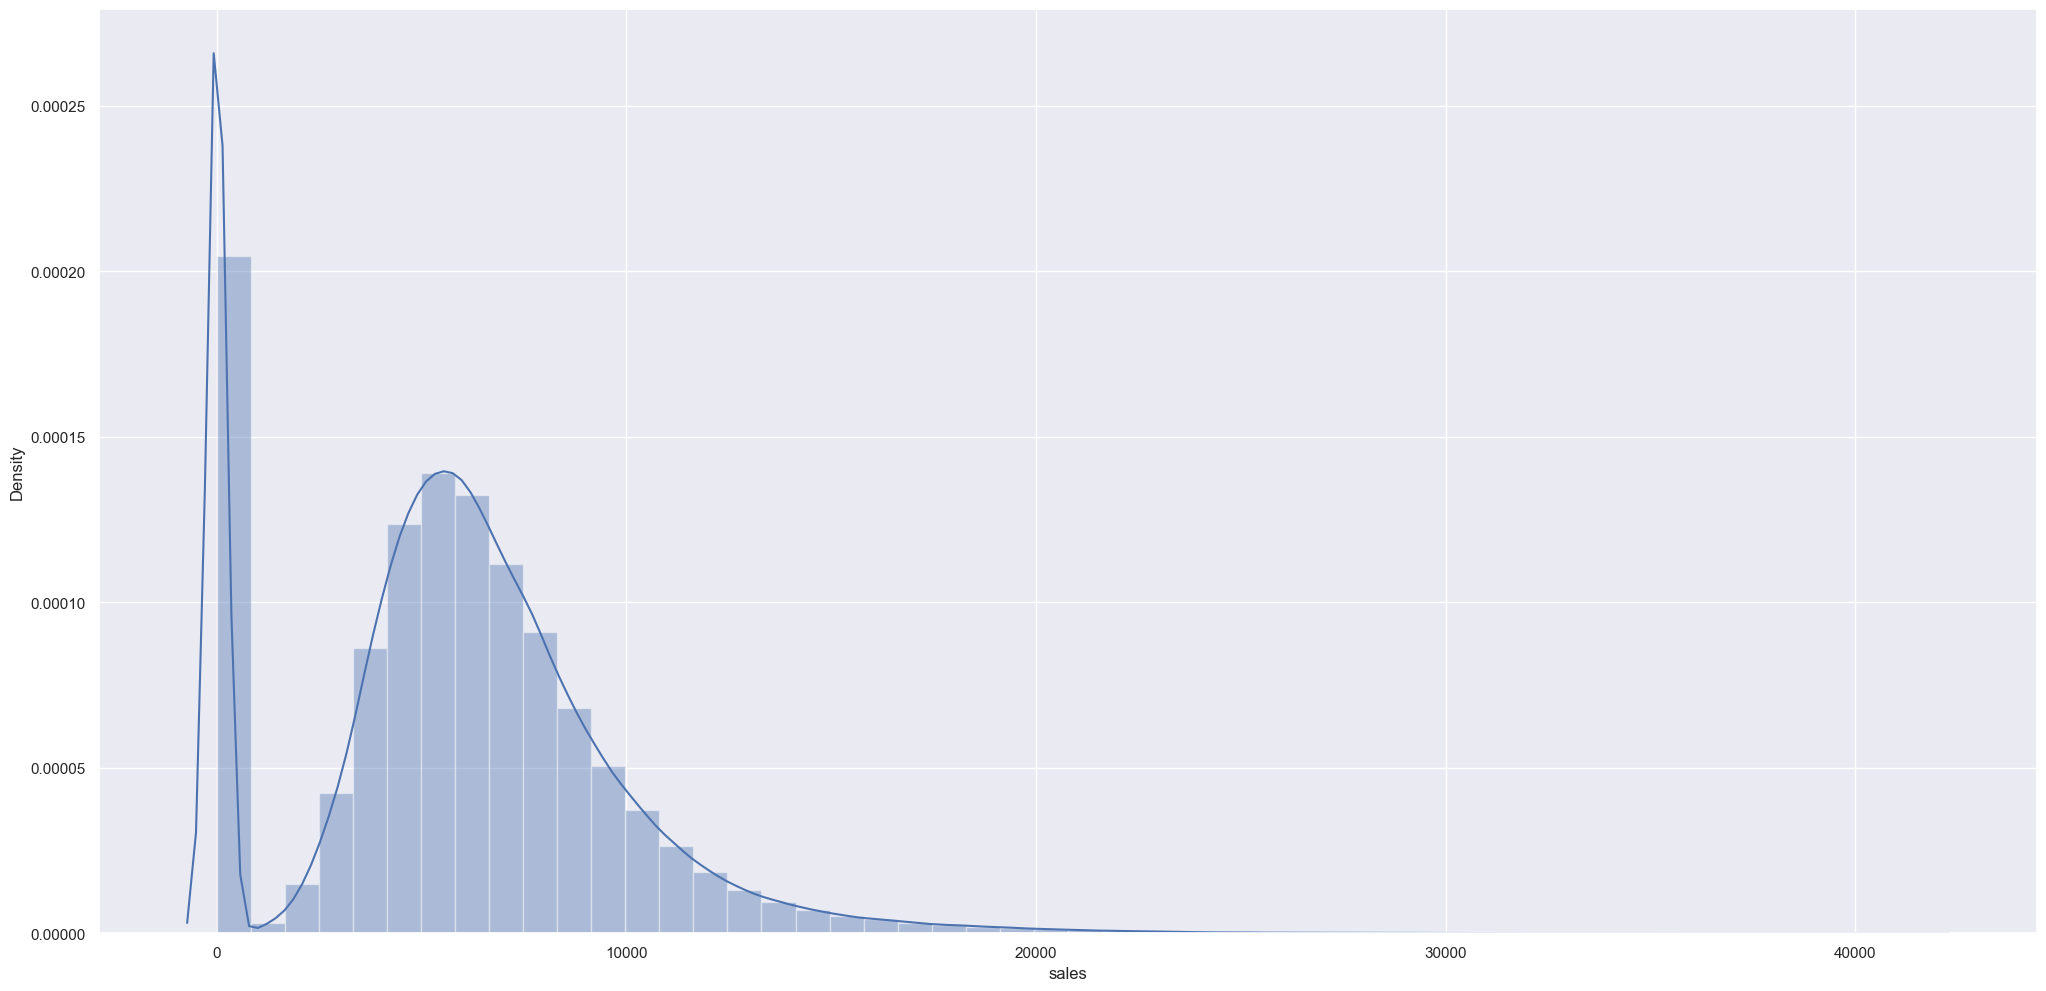

In [173]:
sns.distplot(df1['sales'])
## Curva próxima da normal (media e mediana parecidas), como  a kurtosis é positiva, existe um deslocamento para a esquerda

<AxesSubplot: xlabel='competition_distance', ylabel='Density'>

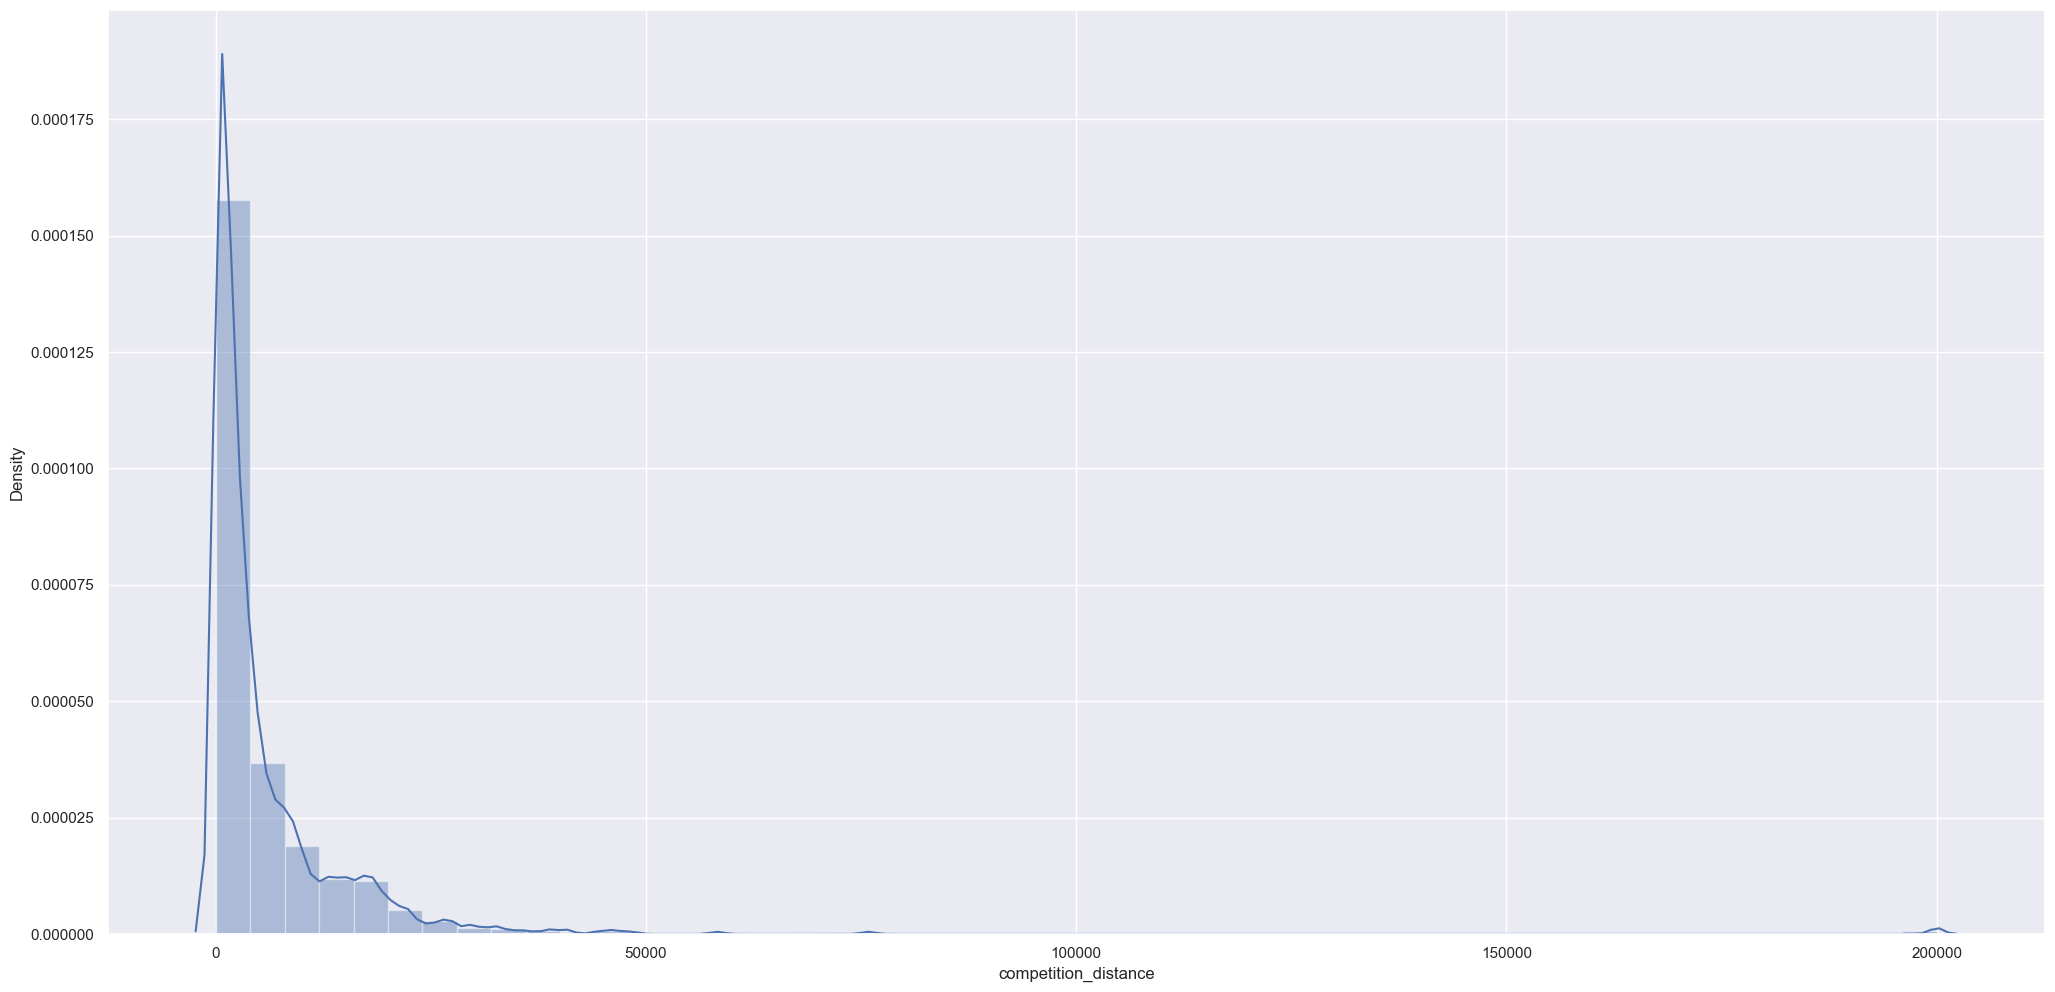

In [174]:
sns.distplot(df1['competition_distance'])
# Curva com um pico muito alto - poison: distância entre os competidores próxima do zero (alta concentração - kurtosis muito positiva)

<AxesSubplot: xlabel='customers', ylabel='Density'>

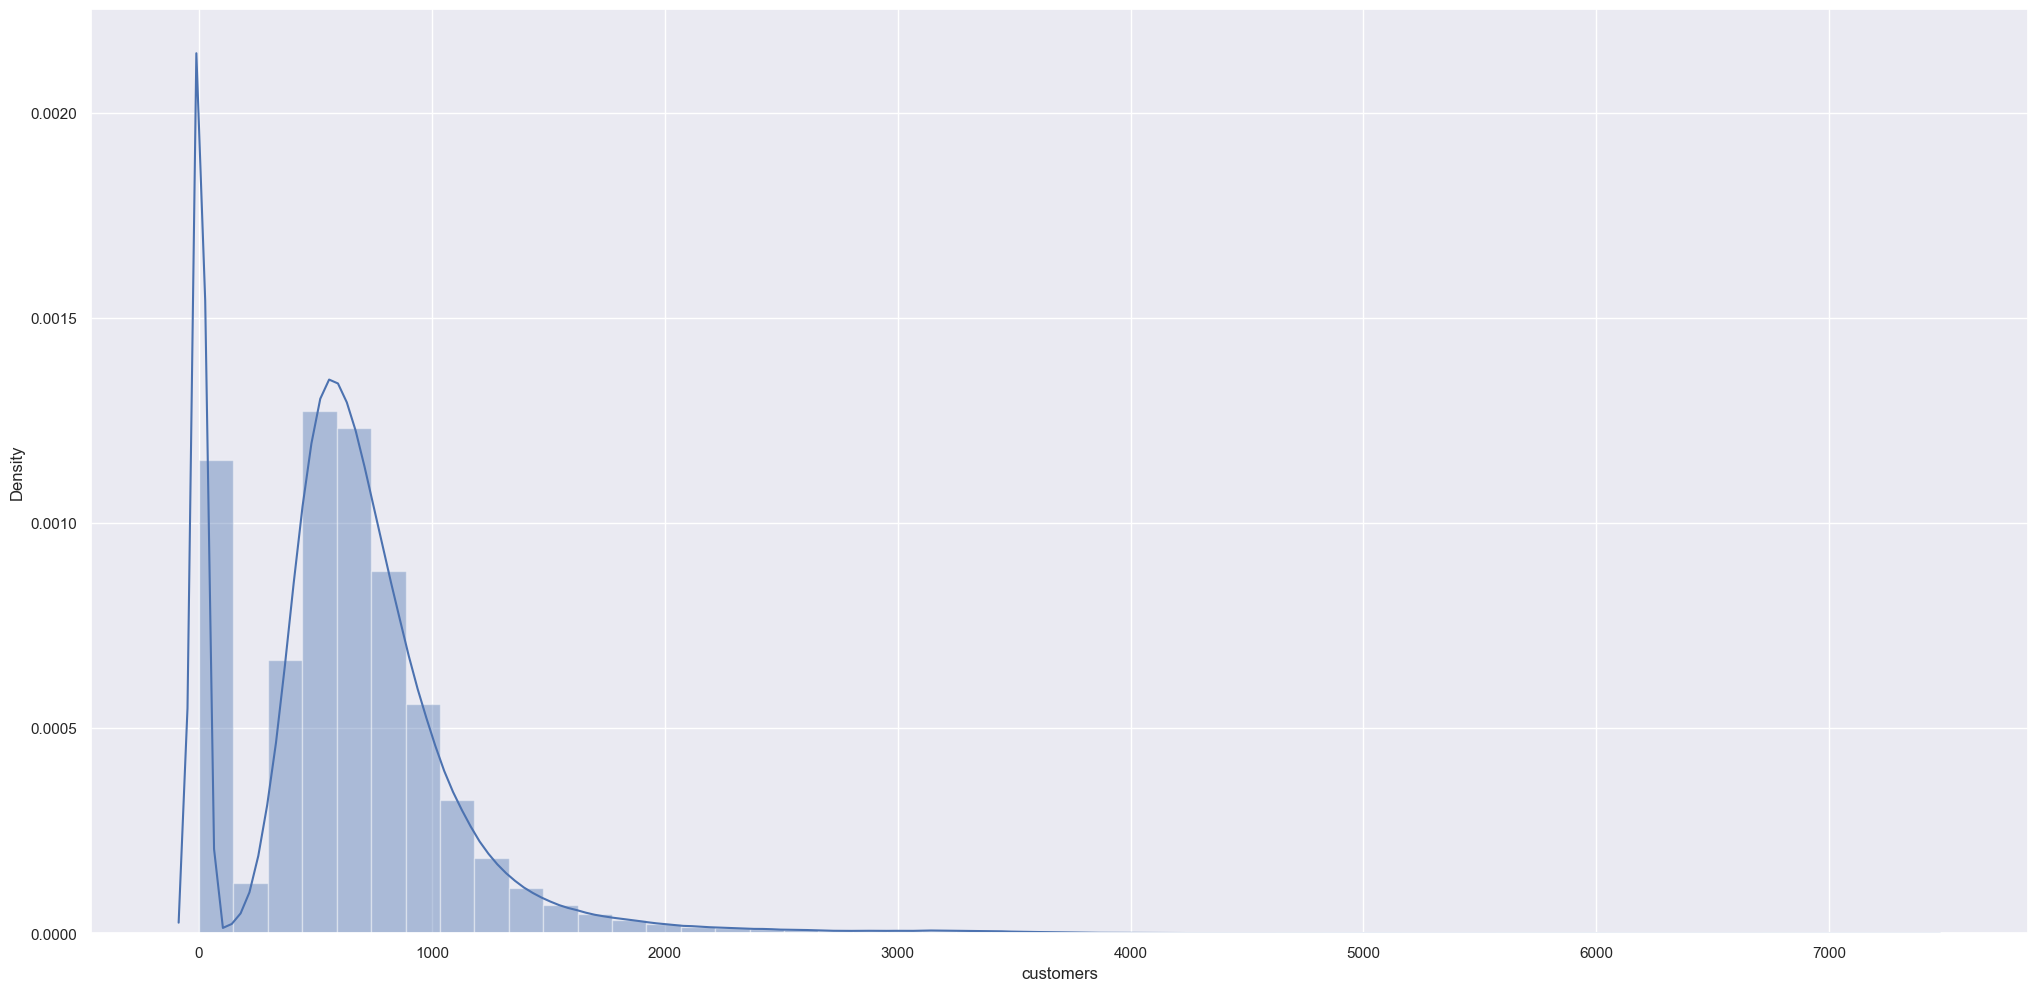

In [175]:
sns.distplot(df1['customers'])
# Pessoas circulando na loja

### 1.7.2 Categorical attributes

In [176]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

In [178]:
df1.groupby(['state_holiday']).size()

state_holiday
0    986159
a     20260
b      6690
c      4100
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

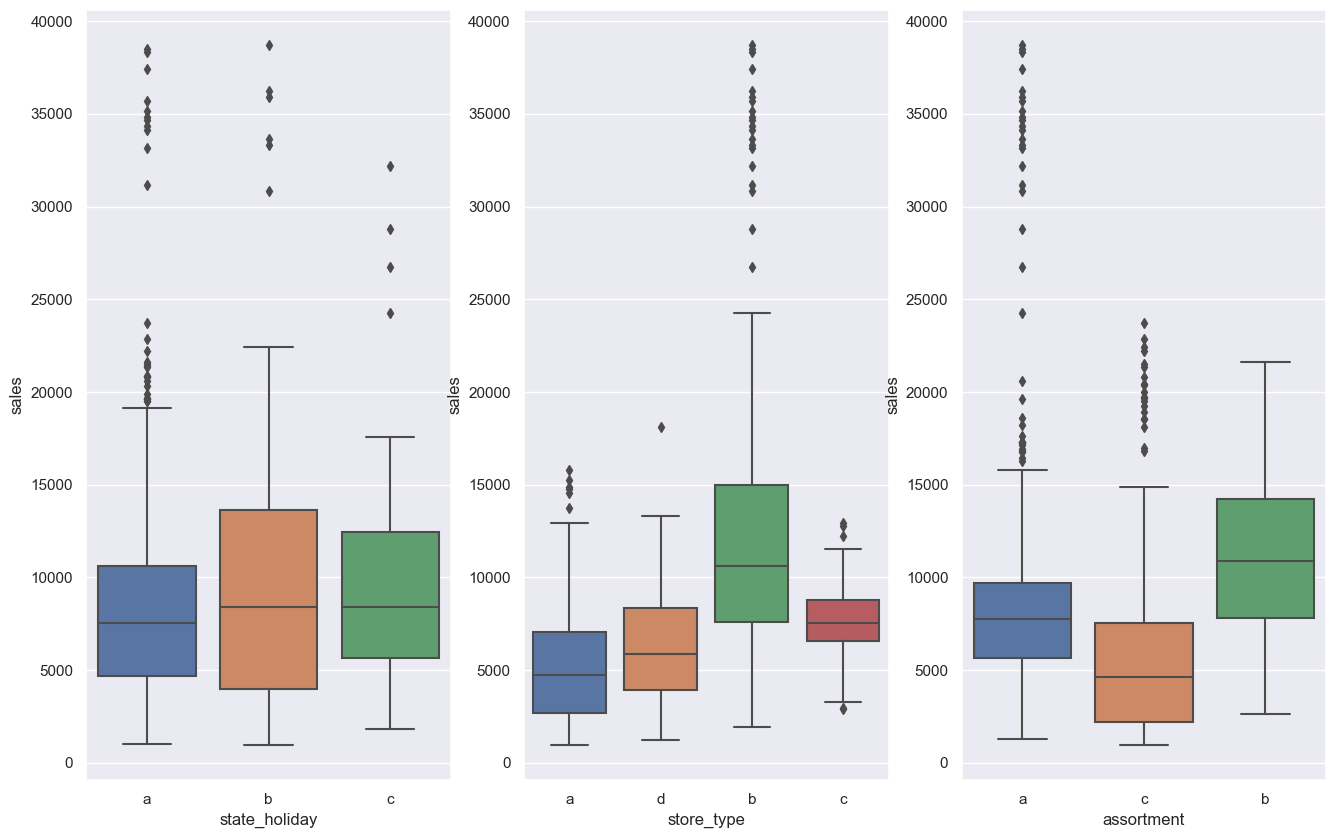

In [179]:
aux1 = df1[(df1['state_holiday']!= '0') & (df1['sales']>0)] # Retira as vendas = zero (loja estava fechada)

plt.figure(figsize =(16,10))
plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux1)

In [28]:
### a, b,c é o tipo de loja, tipo de feriado e variedade
### outlier é 3x o valor do desvio-padrão
### StateHoliday: Feriado 
# O feriado b está em equilíbrio nos quartis, o feriado c apresenta uma alta nas vendas acima da mediana
# Storetype: tipo de loja - a loja b possui vendas acima da média e também tem muito mais outliers, na c a mediana é alta, mas tem uma concentração próxima da mediana
# Assortment (sortimento/variedade): maior parte dos mix de produtos estão no mix b. a e c tem mais outliers

## 2.0 Passo 2: Feature Engineering

In [180]:
# Cópia do DataFrame
df2 = df1.copy()

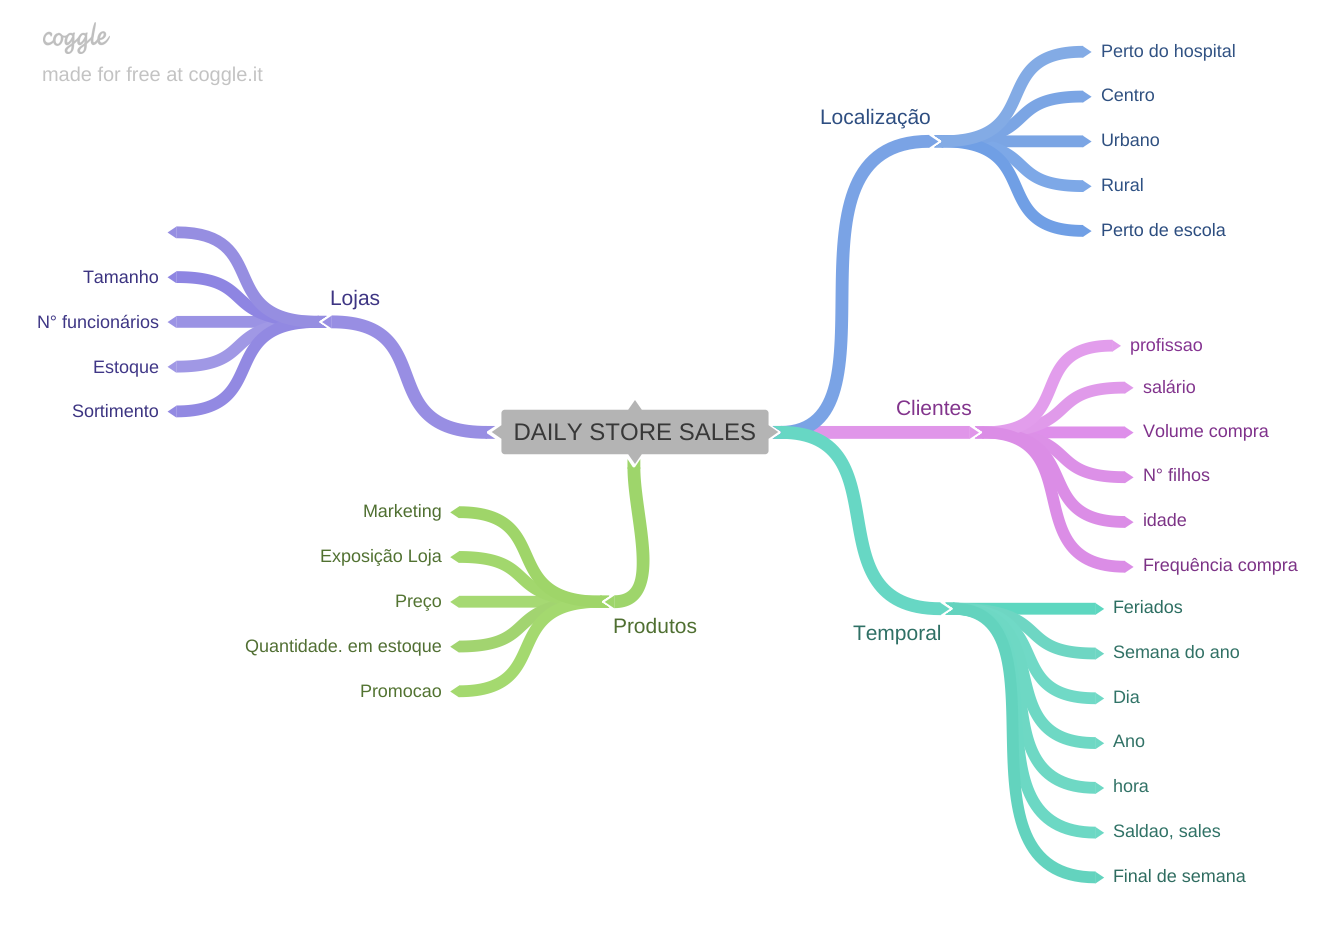

In [37]:
Image('img/MindMap_hipoteses.png')

### 2.1 Criação de Hipóteses

#### 2.1.1 Hipóteses relacionadas às lojas

**1.** Lojas com quadro de funcionários maior deveriam vender mais

**2.** Lojas com estoque maior deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com sortimento maior deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores há mais tempo deveriam vender mais


#### 2.1.2 Hipóteses relacionadas aos Produtos

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoem mais os produtos na vitrine deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender menos

**5.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas mais promoções consecutivas deveriam vender mais

#### 2.1.3 Hipóteses relacionadas ao tempo

**1.** Lojas abertas durante o feriado de natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares



### 2.2 Lista final de Hipóteses (Priorização)

**1.** Lojas com sortimento maior deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores há mais tempo deveriam vender mais


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas mais promoções consecutivas deveriam vender mais


**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos nos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

### 2.3 Feature engineering

In [181]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [182]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [183]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [184]:
df2.groupby(['state_holiday']).size()

state_holiday
0    986159
a     20260
b      6690
c      4100
dtype: int64

In [185]:
## Derivando features da data: novas colunas ###

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since (Quanto tempo tem desde que a competição começou): granularidade 30 = mês

df2['competition_since'] = df2.apply (lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)

# nova coluna: promo since (Quanto tempo tem a promoção): ano e semana, tem que modificar para mês
# Tem que transformar em string para fazer o join; converte para data para poder fazer a subtração
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# nova coluna: promo_time_week: tempo que a promoção está ativa em semanas
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment: trocando os níveis a, b, c por basic, extra, extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday: trocando a,b,c por Tipos de feriados: Public holiday, Easter holiday, Christmas
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [186]:
df2.groupby(['state_holiday']).size()

state_holiday
christmas           4100
easter_holiday      6690
public_holiday     20260
regular_day       986159
dtype: int64

In [187]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 Passo 3 - Filtragem de variáveis

In [188]:
df3 = df2.copy()

In [189]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtragem das linhas

In [190]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [191]:
# Filtra as linhas em que open é 1 (ou seja é quando a loja está aberta) e sales diferente de zero (quando a loja está aberta) 
df3 = df3[(df3['open'] != 0) & (df3['sales'] >0)]


### 3.2 Seleção das colunas

In [192]:
# Apaga as colunas customers (que diz quantos clientes entrram na loja e fizeram compras - mas não tem como 
# fazer a previsão de 6 semanas); Open (as linhas que sobraram e são zero); 
# PromoInterval e month-map (colunas utilizadas para derivar outras colunas)
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

## 4.0 EDA - Exploração e Análise de Dados

In [193]:
# EDA - Serve para analisar o impacto das variáveis sobre o fenômeno e qual a sua força.
# Ganhar experiência de negócio; validar as hipóteses e gerar insights; 
# Perceber as variáveis que são importantes para o modelo
df4 = df3.copy()

### 4.1 Análise UNIVARIADA

#### 4.1.1 Response Variable 

<AxesSubplot: xlabel='sales'>

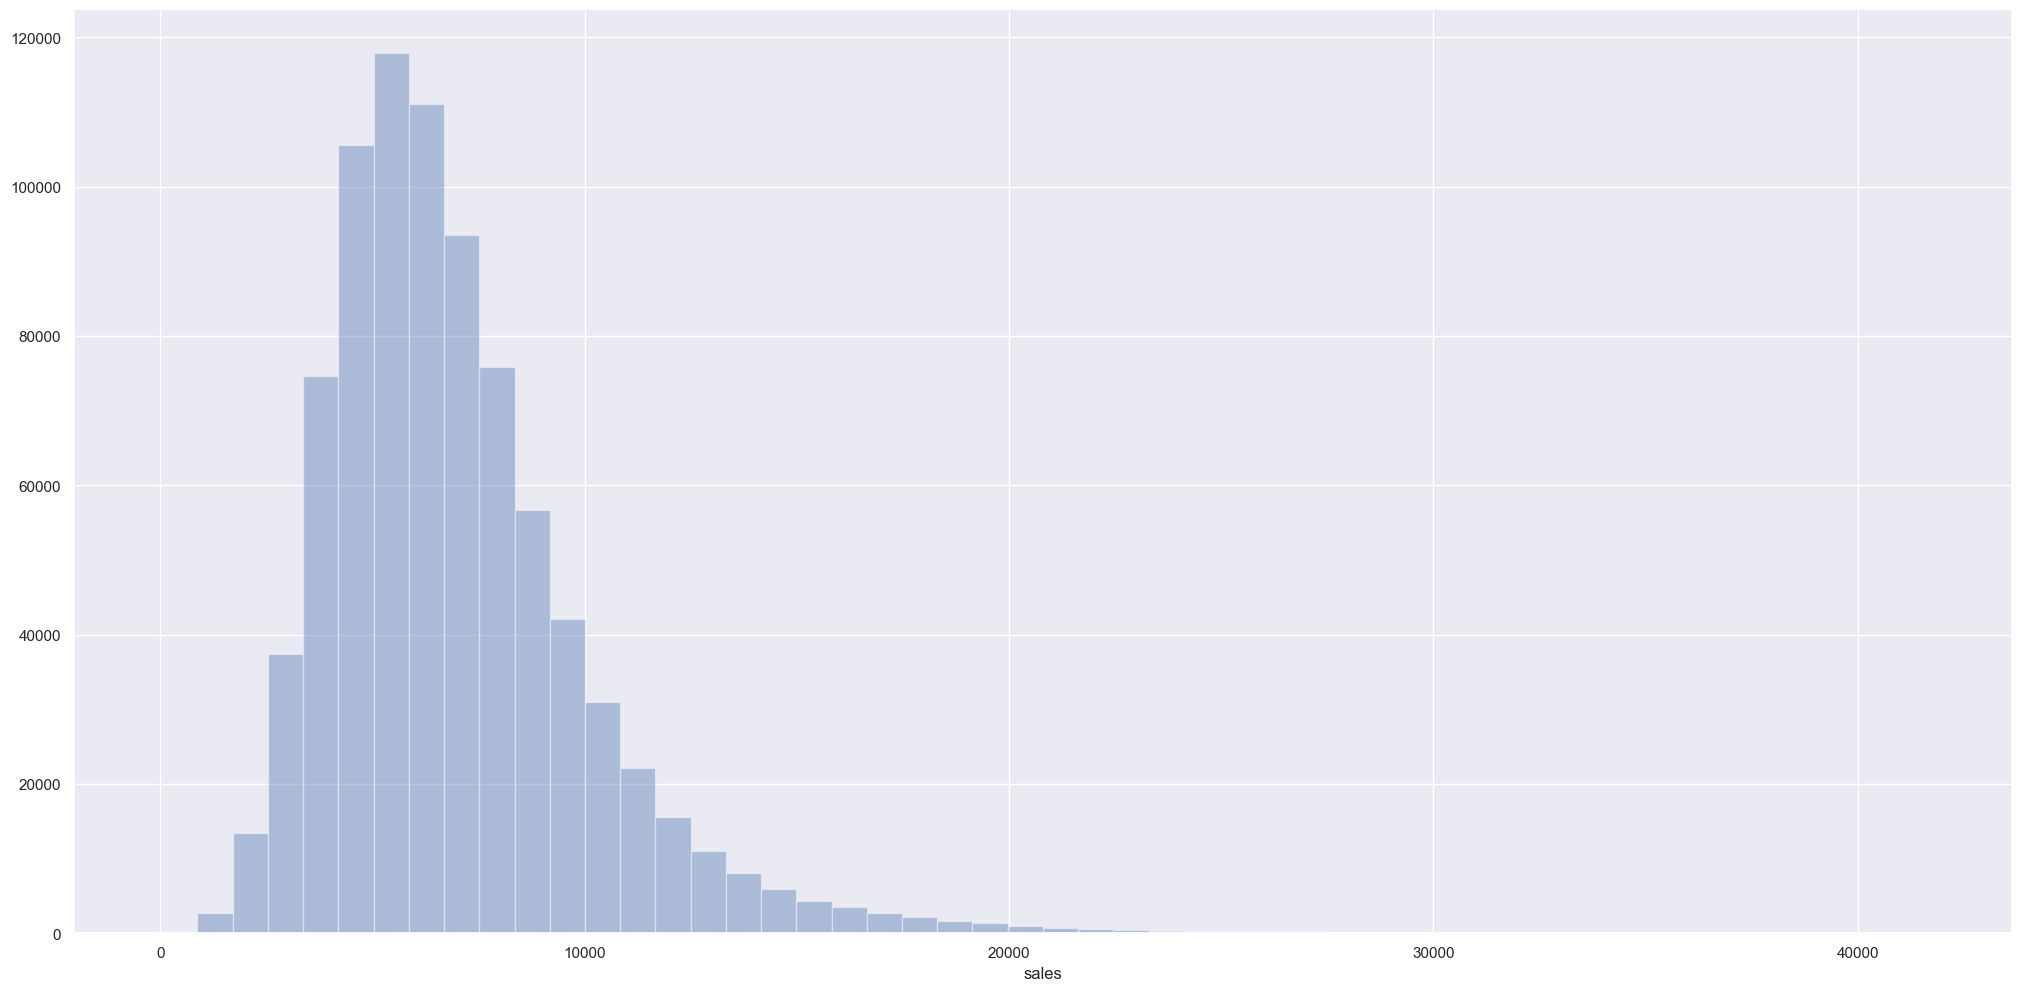

In [194]:
# Gráfico da variável resposta
sns.distplot(df4['sales'],kde=False)
# Próxima de uma curva normal (mas não é), porque não tem um centro: possui uma kurtose (cauda), skew para esquerda (positiva)

#### 4.1.2 Numerical Variable

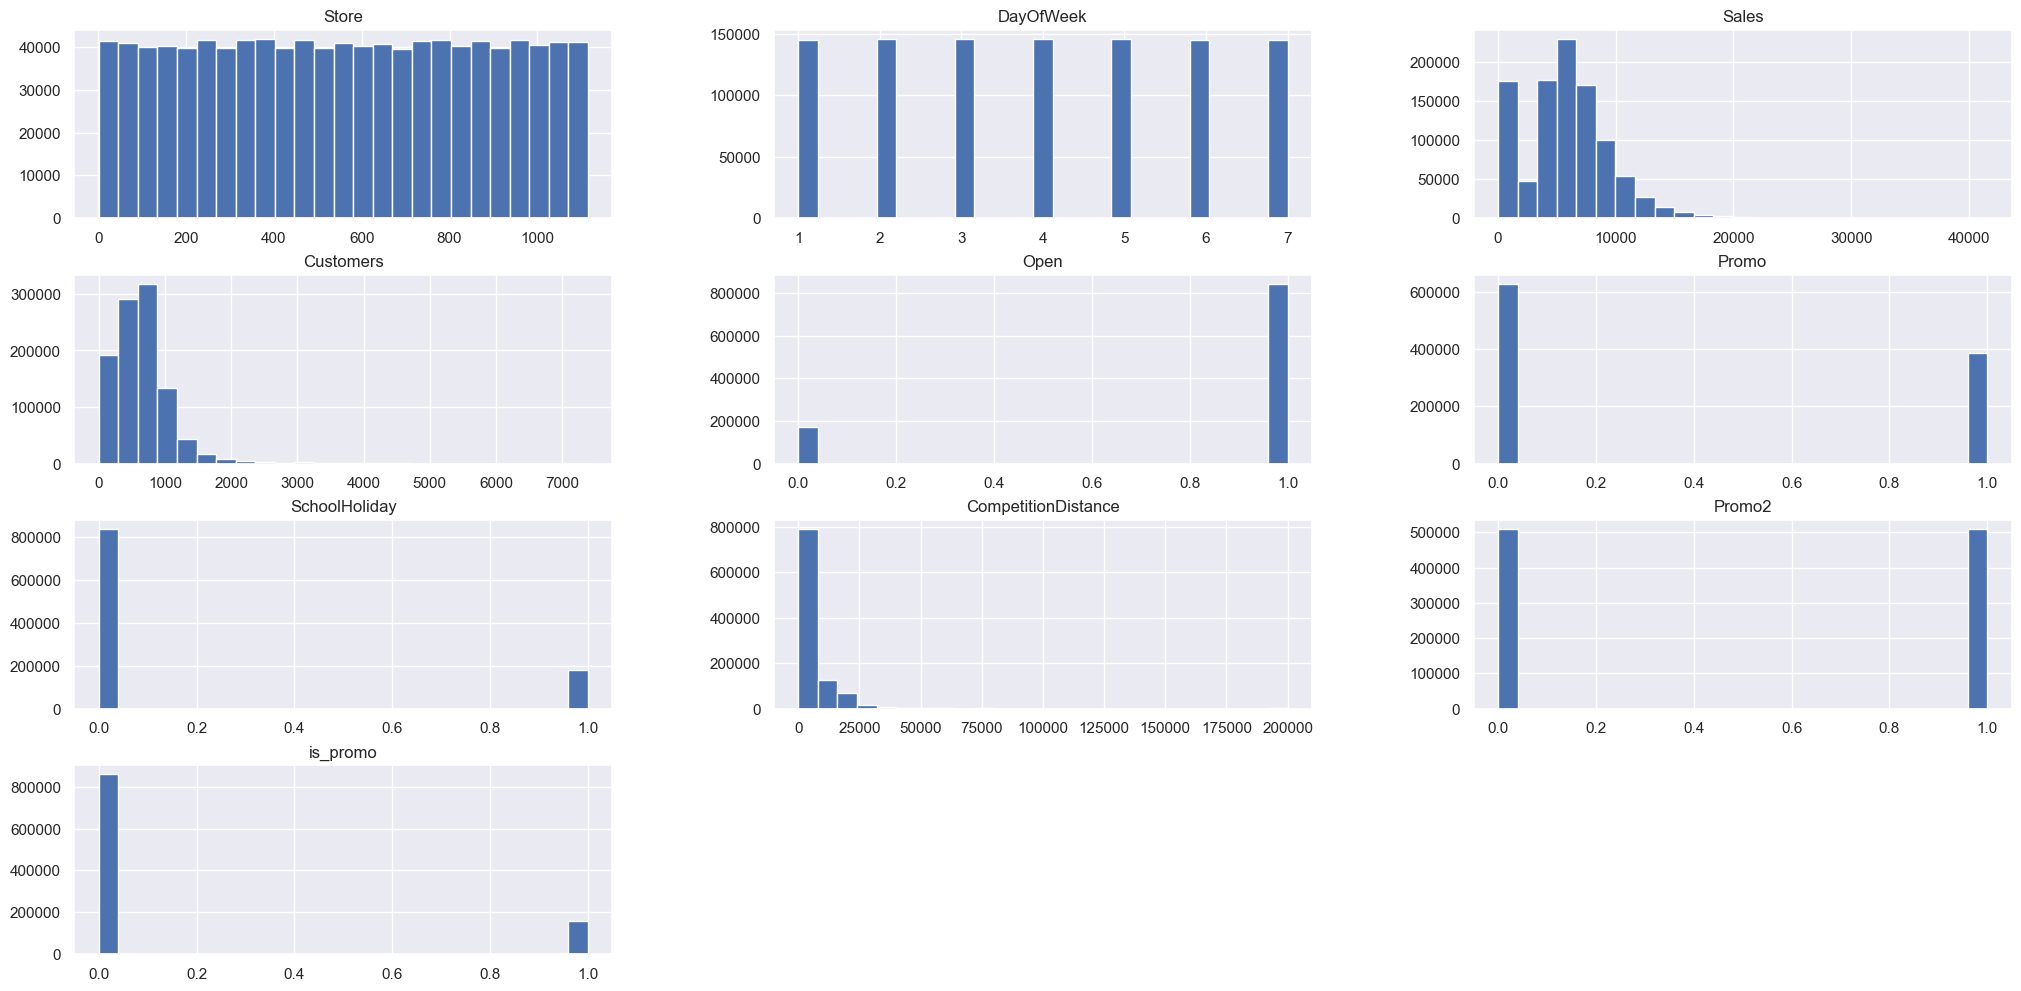

In [44]:
num_attributes.hist(bins=25);


# Todos os competidores estão próximos (distância menor)
# competiition_opne_since_month: demonstra um comportamento
# Day_of_week não tem diferença entre os dias de vendas (não é boa para o modelo)
# ver de novo aula 12 modulo 04

#### 4.1.3 Categorical Variable

In [195]:
df4.groupby(['state_holiday']).size()

state_holiday
christmas             71
easter_holiday       145
public_holiday       694
regular_day       843428
dtype: int64

In [196]:
df4.shape

(844338, 25)

In [197]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

<AxesSubplot: xlabel='sales', ylabel='Density'>

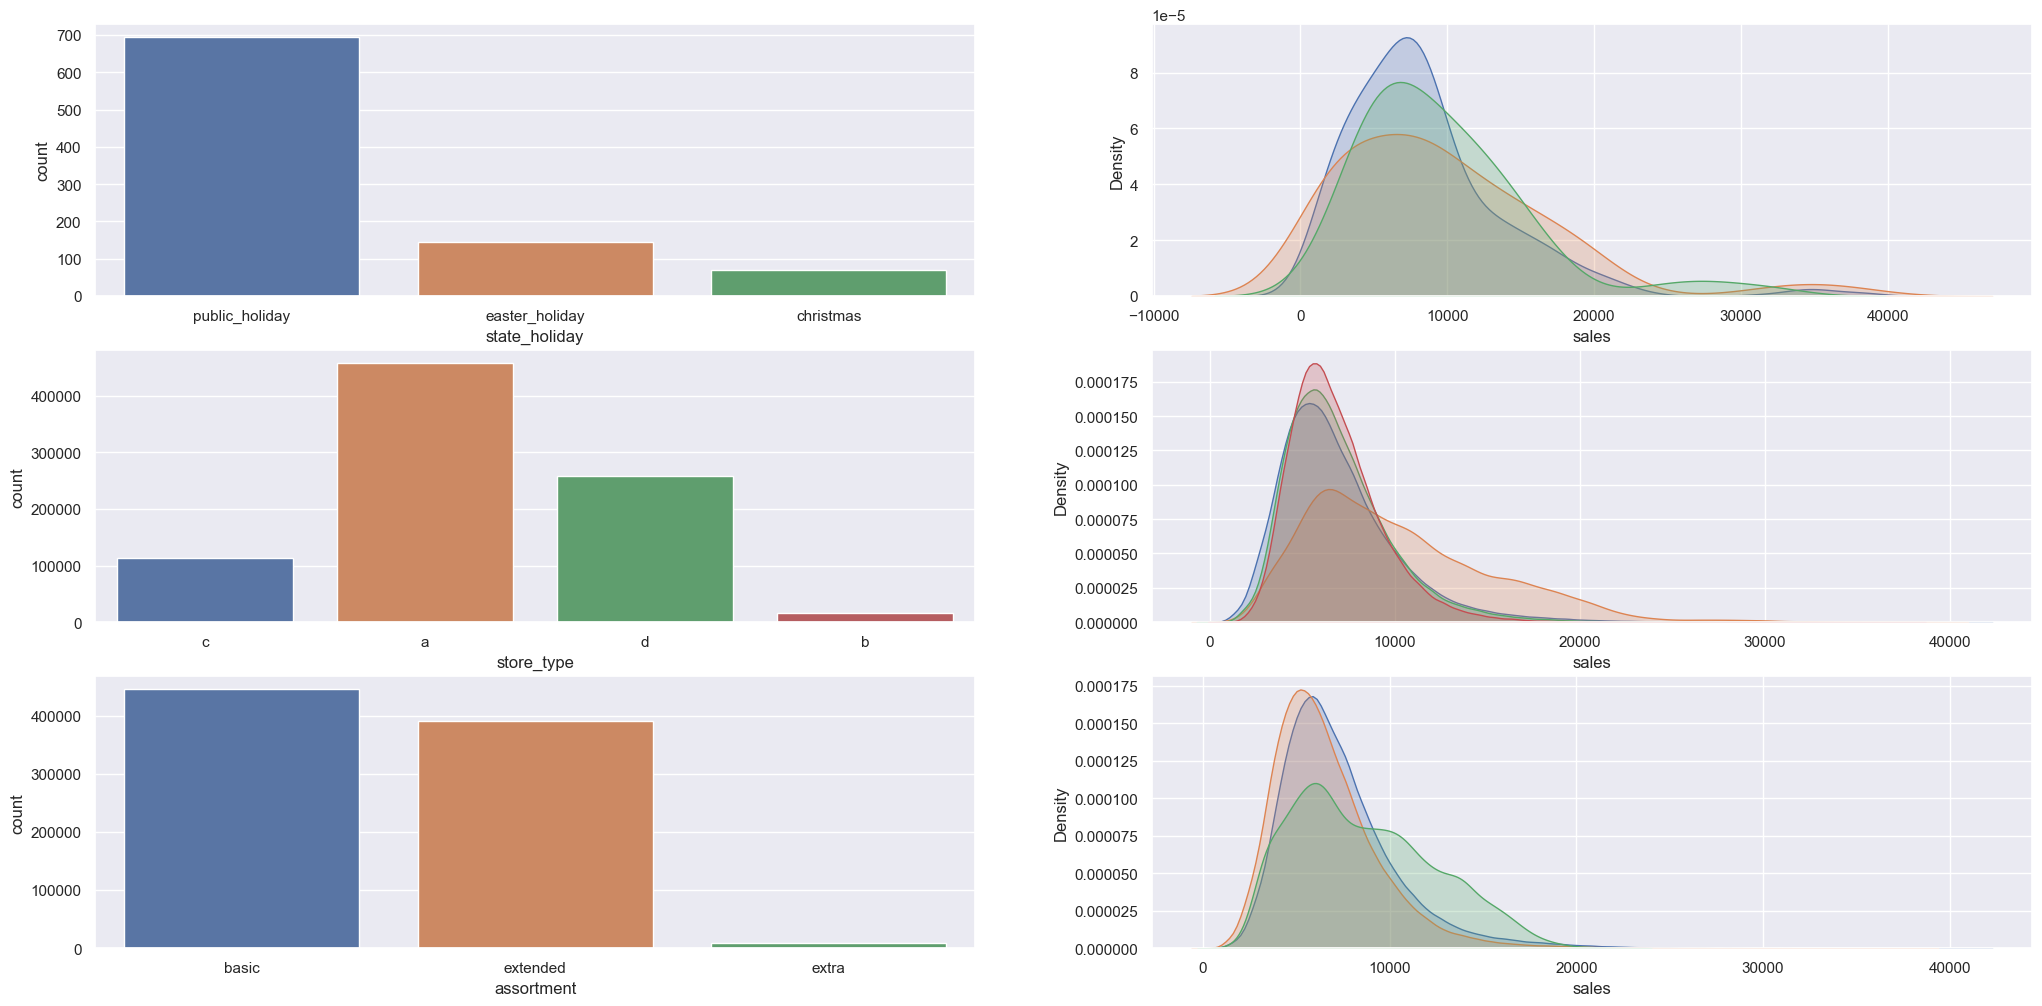

In [200]:
# contar quantas linhas tenho dentro das variáveis categóricas 

# StateHoliday
plt.subplot( 3,2,1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'] )
#
plt.subplot( 3,2,2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True )
#
# StoreType
plt.subplot( 3,2,3 )
sns.countplot(x = df4['store_type'])

plt.subplot( 3,2,4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True )
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True )
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True )
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True )
#
## Assortment
plt.subplot( 3,2,5 )
sns.countplot(x = df4['assortment'])
#
plt.subplot( 3,2,6 )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True )
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True )
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True )


### 4.2 Análise BIVARIADA

### H1. Lojas com MAIOR sortimento vendem MAIS
###### VERDADEIRA -> Lojas com MAIOR sortimento vendem mais

In [201]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

<AxesSubplot: xlabel='year_week'>

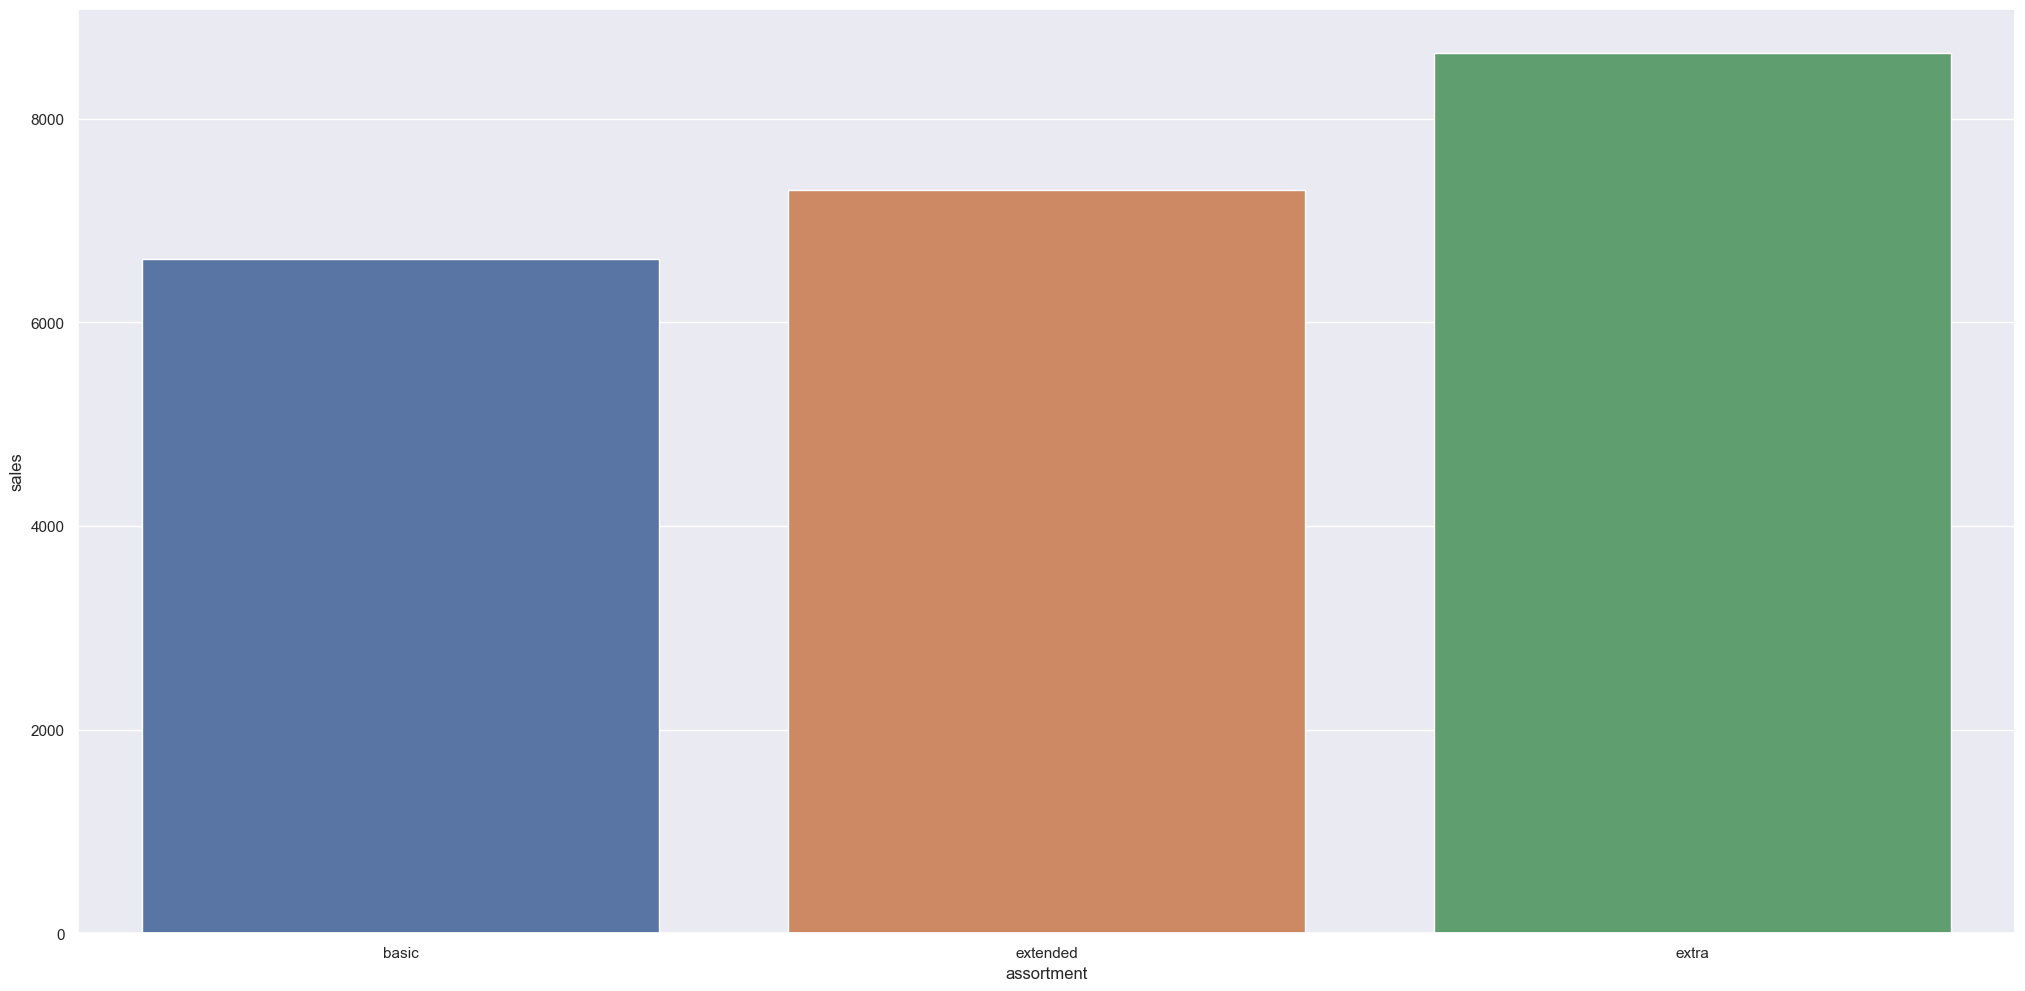

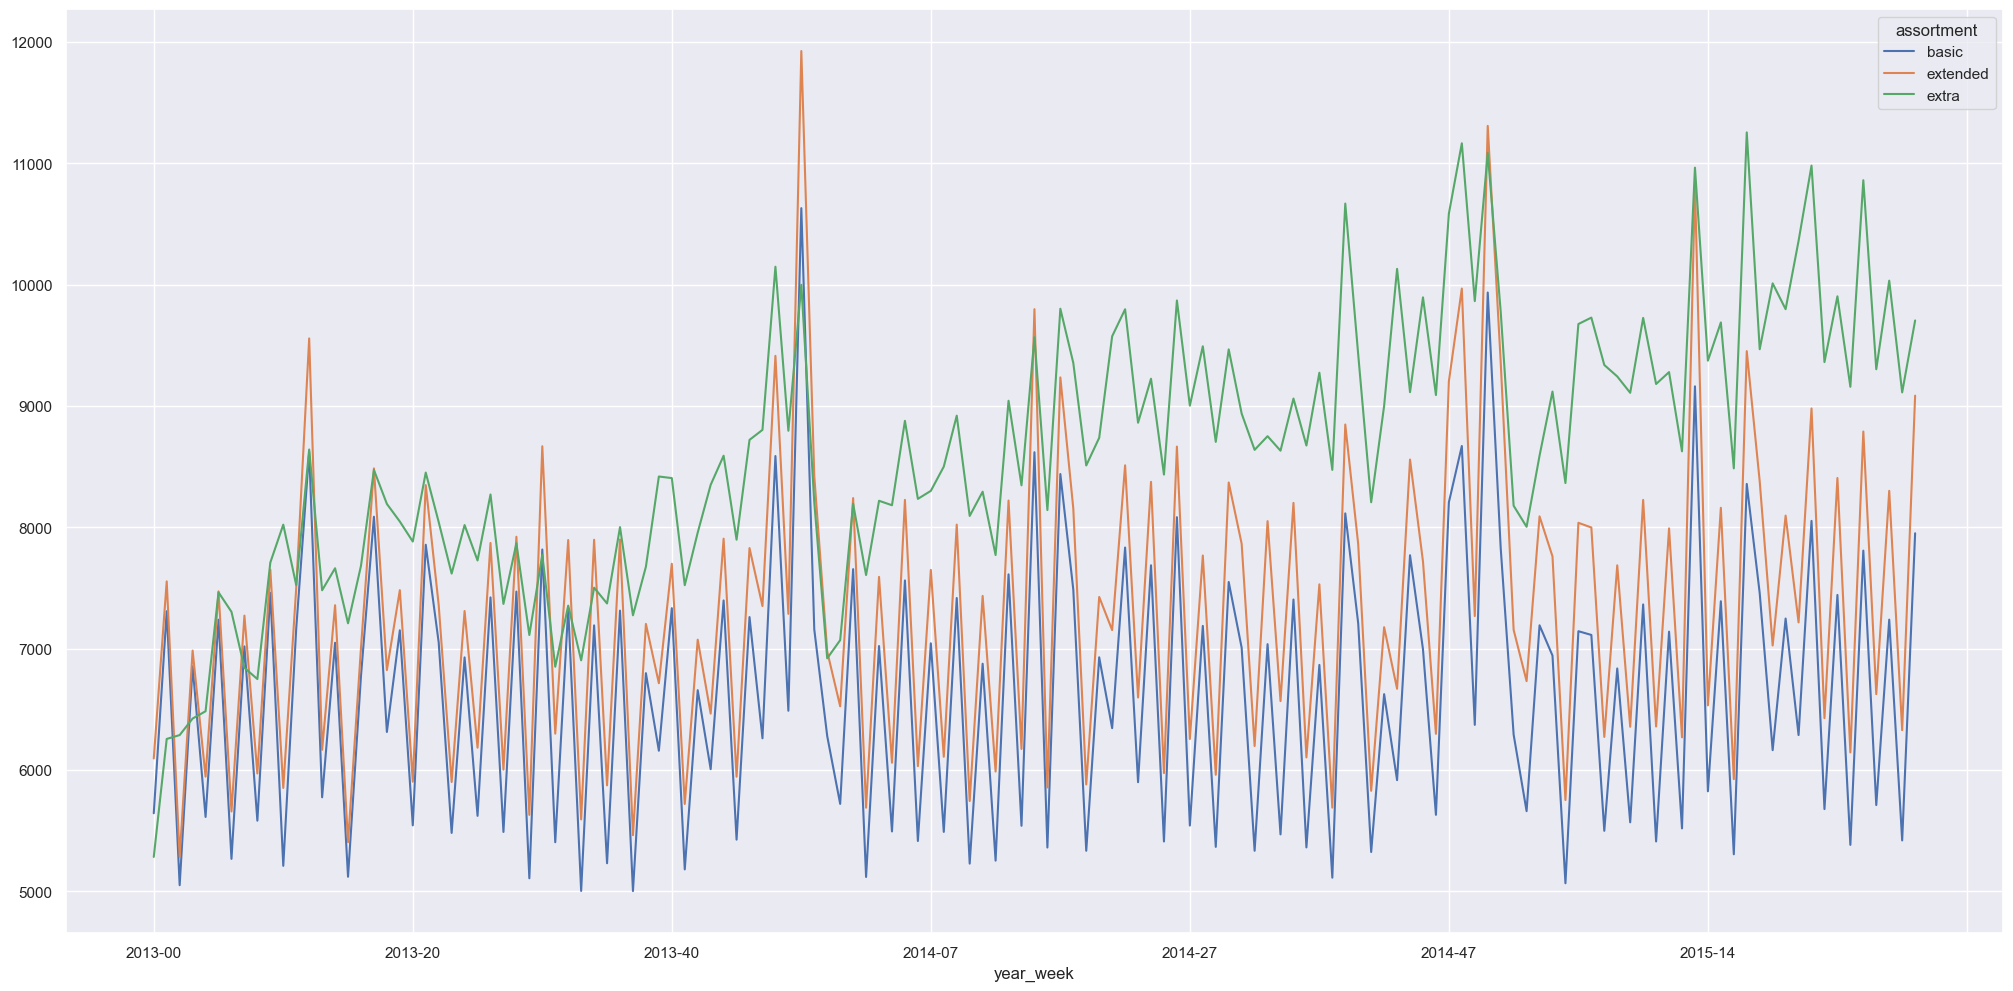

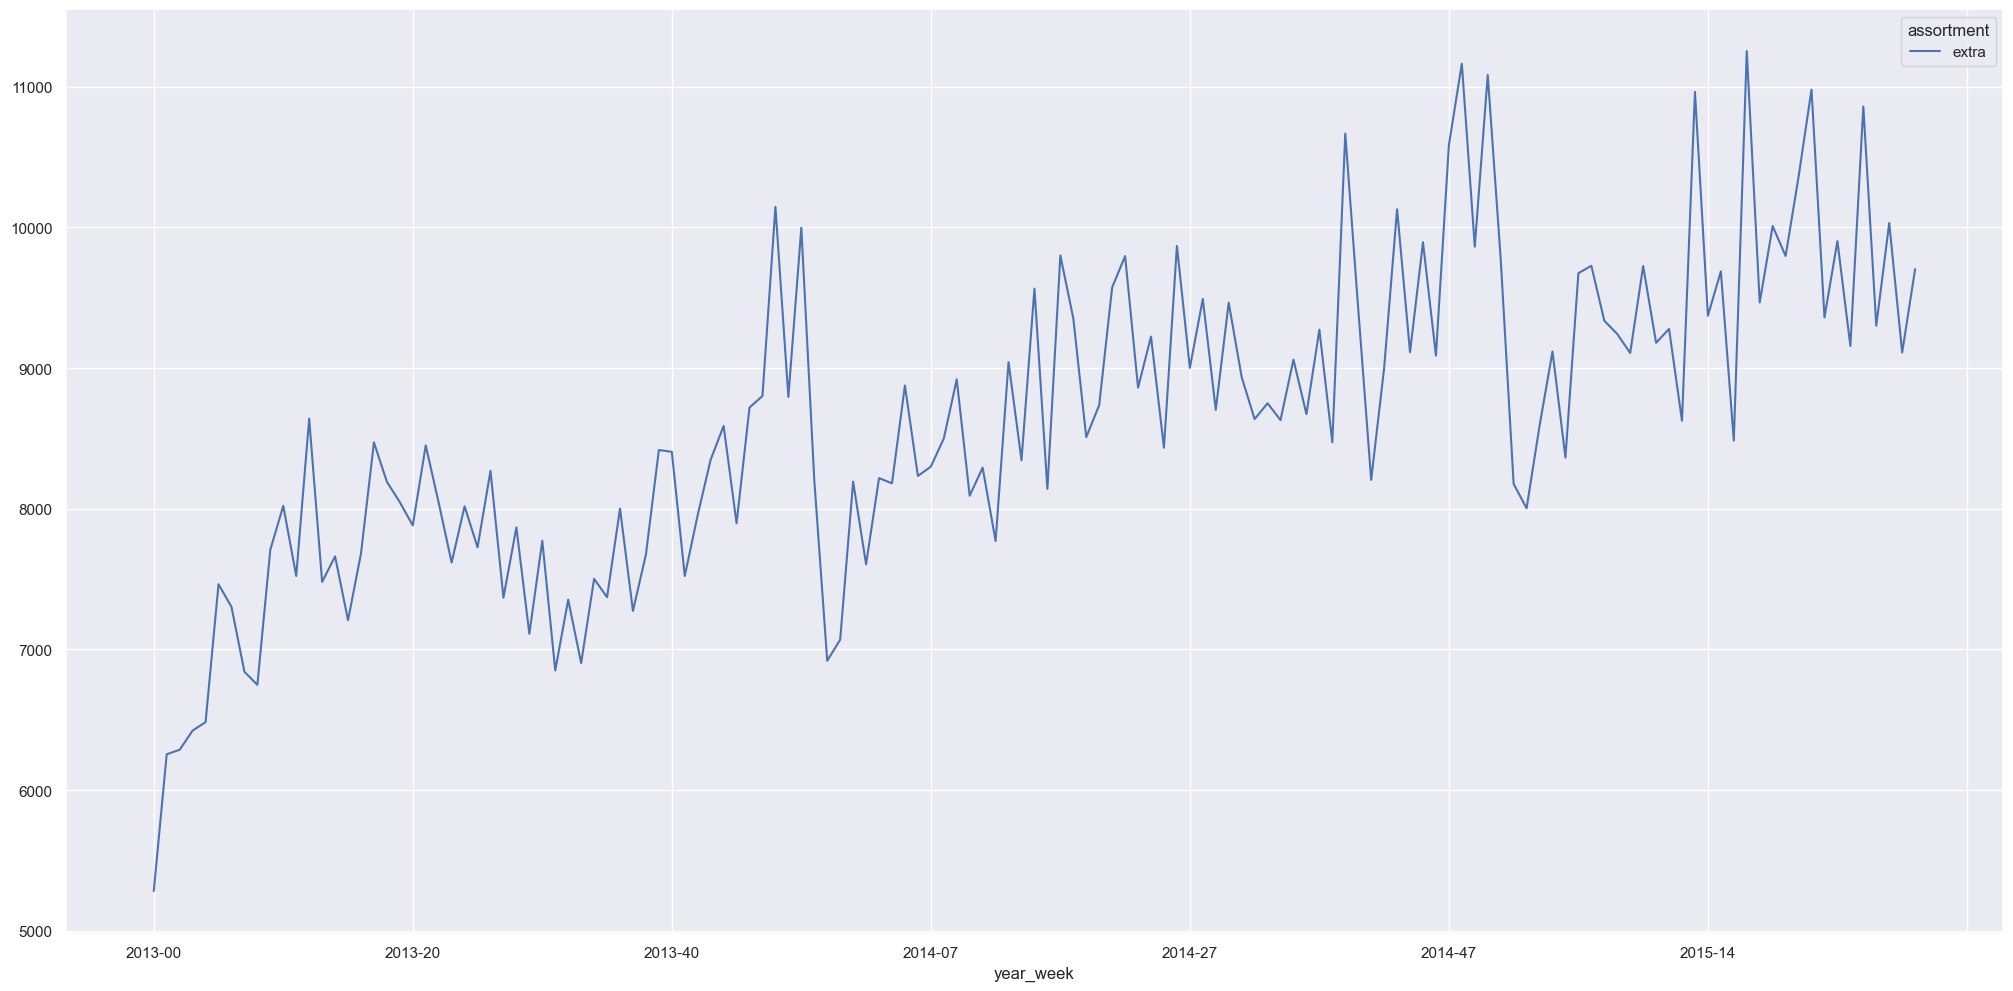

In [274]:
# Média de vendas das lojas que tem sortimento: básico, extendido e extra
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Gráfico para saber se ao longo do tempo (ano e semana), o extra pode ter sido uma estratégia apenas do passado 
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.head()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()
           
# Gráfico para observar apenas o sortimento extra
# Não é linear, tem um comportamento diferente do que aparece no gráfico anterior
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos vendem MENOS
###### FALSA -> Lojas com competidores mais próximos vendem MAIS

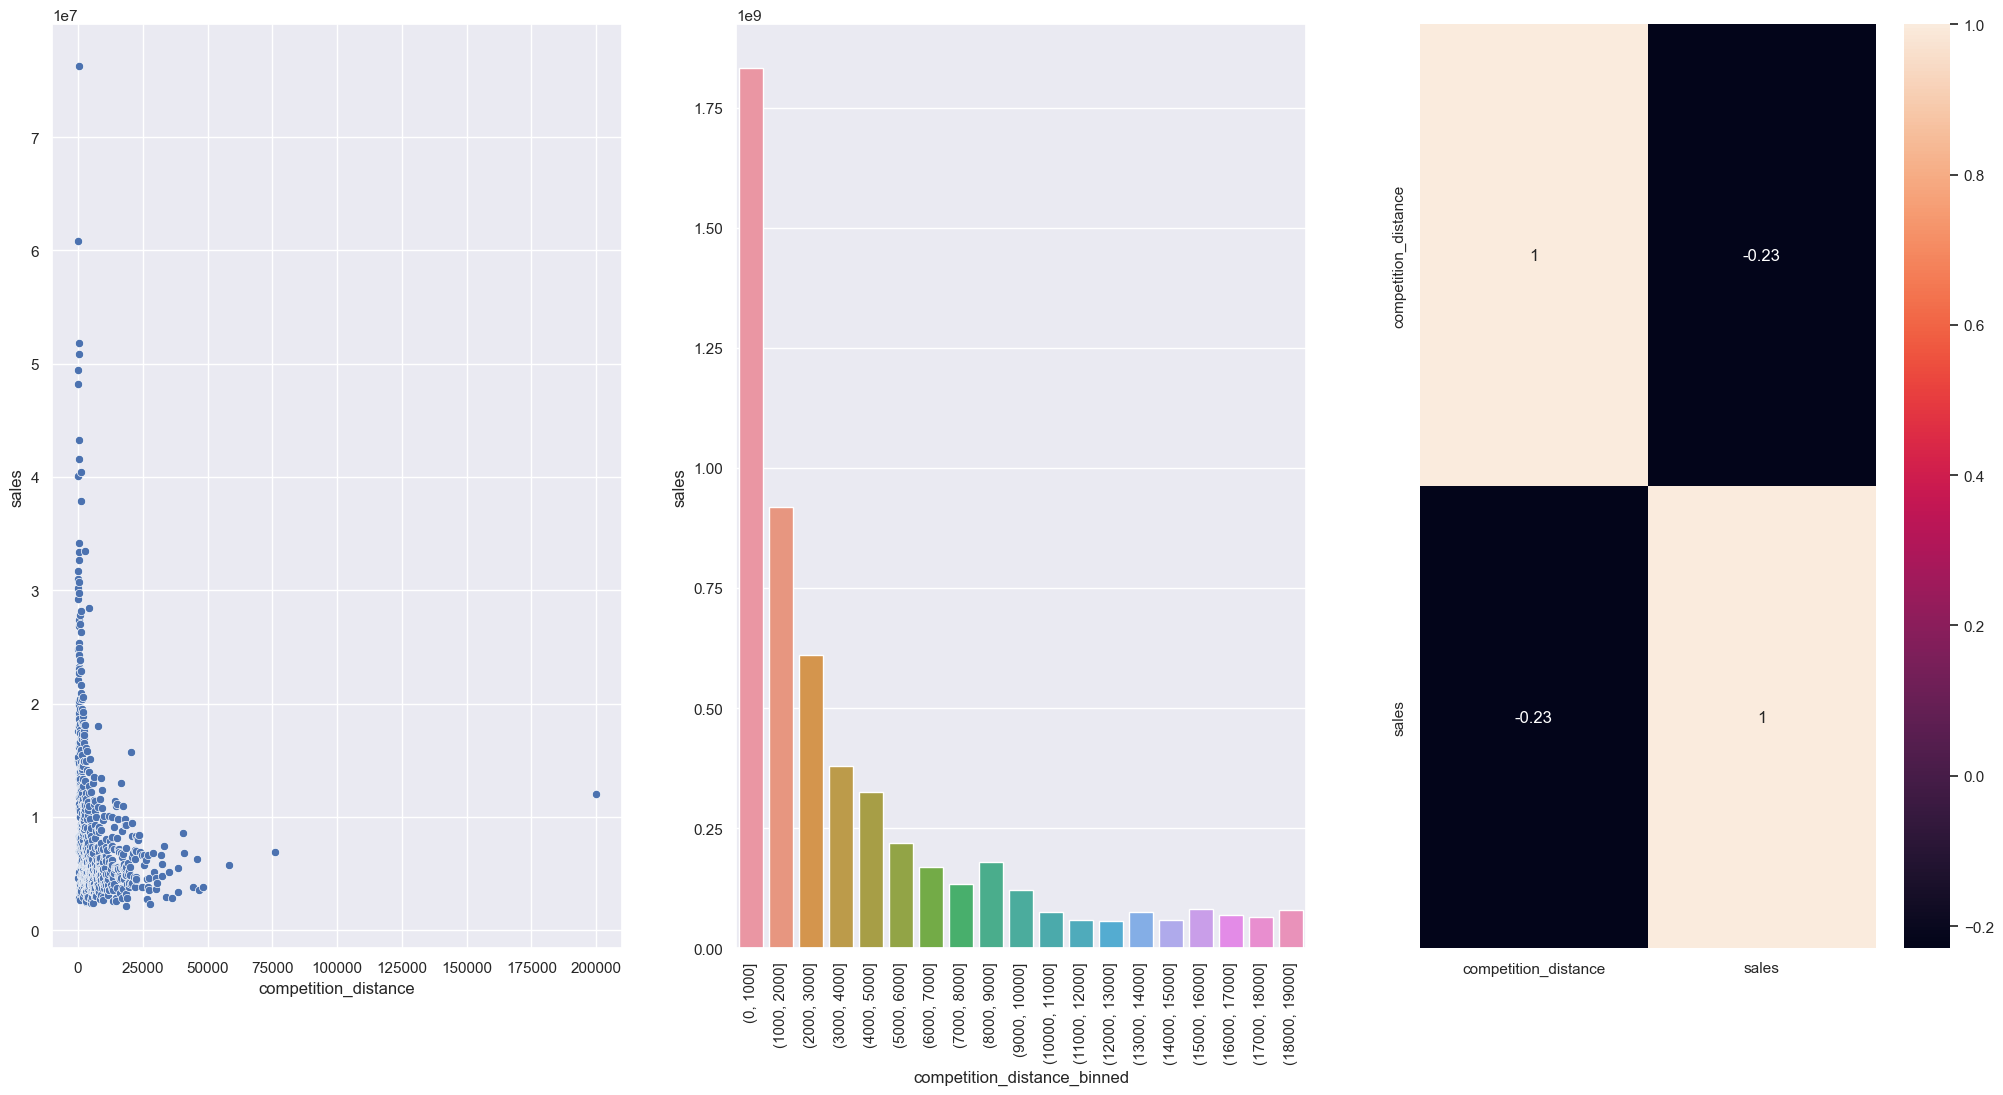

In [203]:

## Correlação de pearson: mais próximo de 1 e próximo de -1 (correlacionados)
# Ver o volume de vendas pela distância dos competidores
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

# Agrupando por distância (bins)
plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Correlação entre as vendas e a distância dos competidores (quanto mais distante, menor a venda: correlação negativa)
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()

### H3. Lojas com competidores há mais tempo vendem MAIS
###### FALSA -> Lojas com competidores há mais tempo vendem MENOS

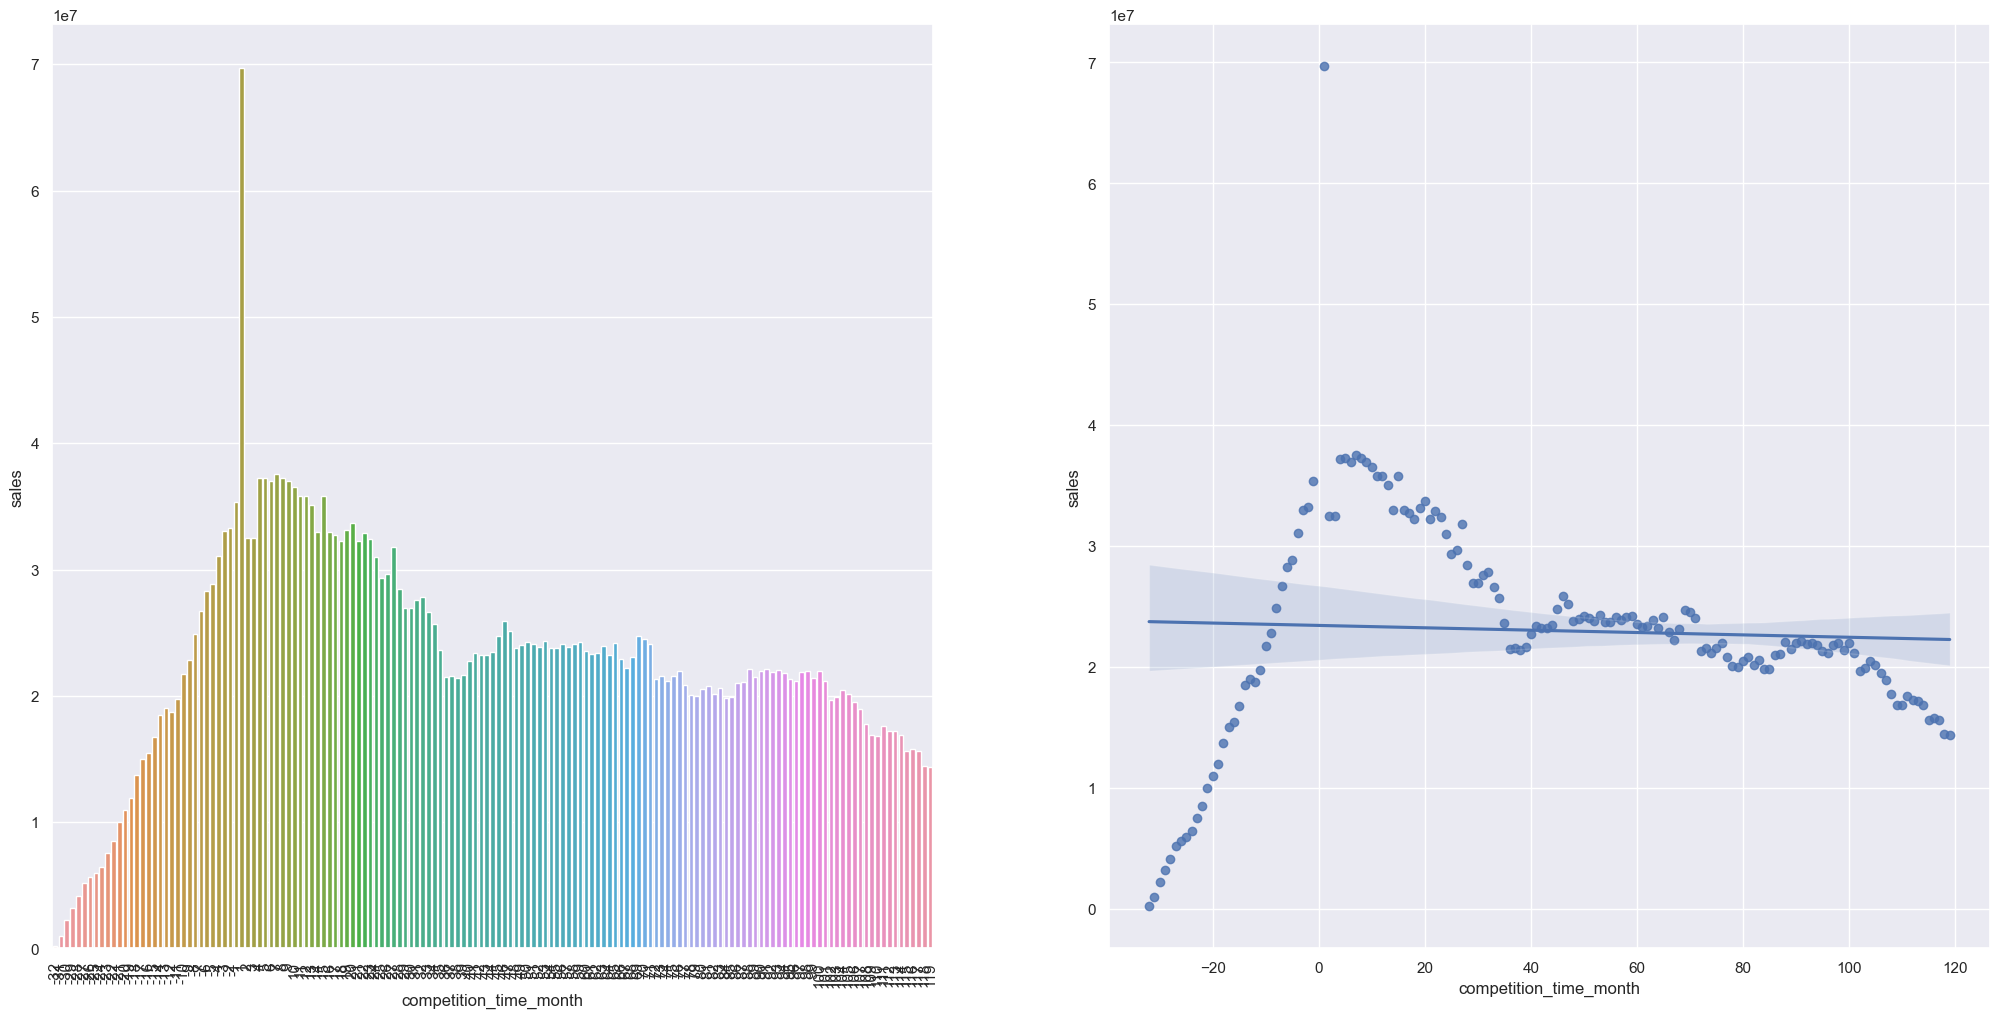

In [204]:

#Como o tempo influencia na venda?
# Quanto mais recente é a competição maior é a venda.
plt.subplot( 1, 2, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

# Filtro: menos de 120 meses e diferentes de zero
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# É preciso usar a coluna de tempo - mês
plt.subplot( 1, 2, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );


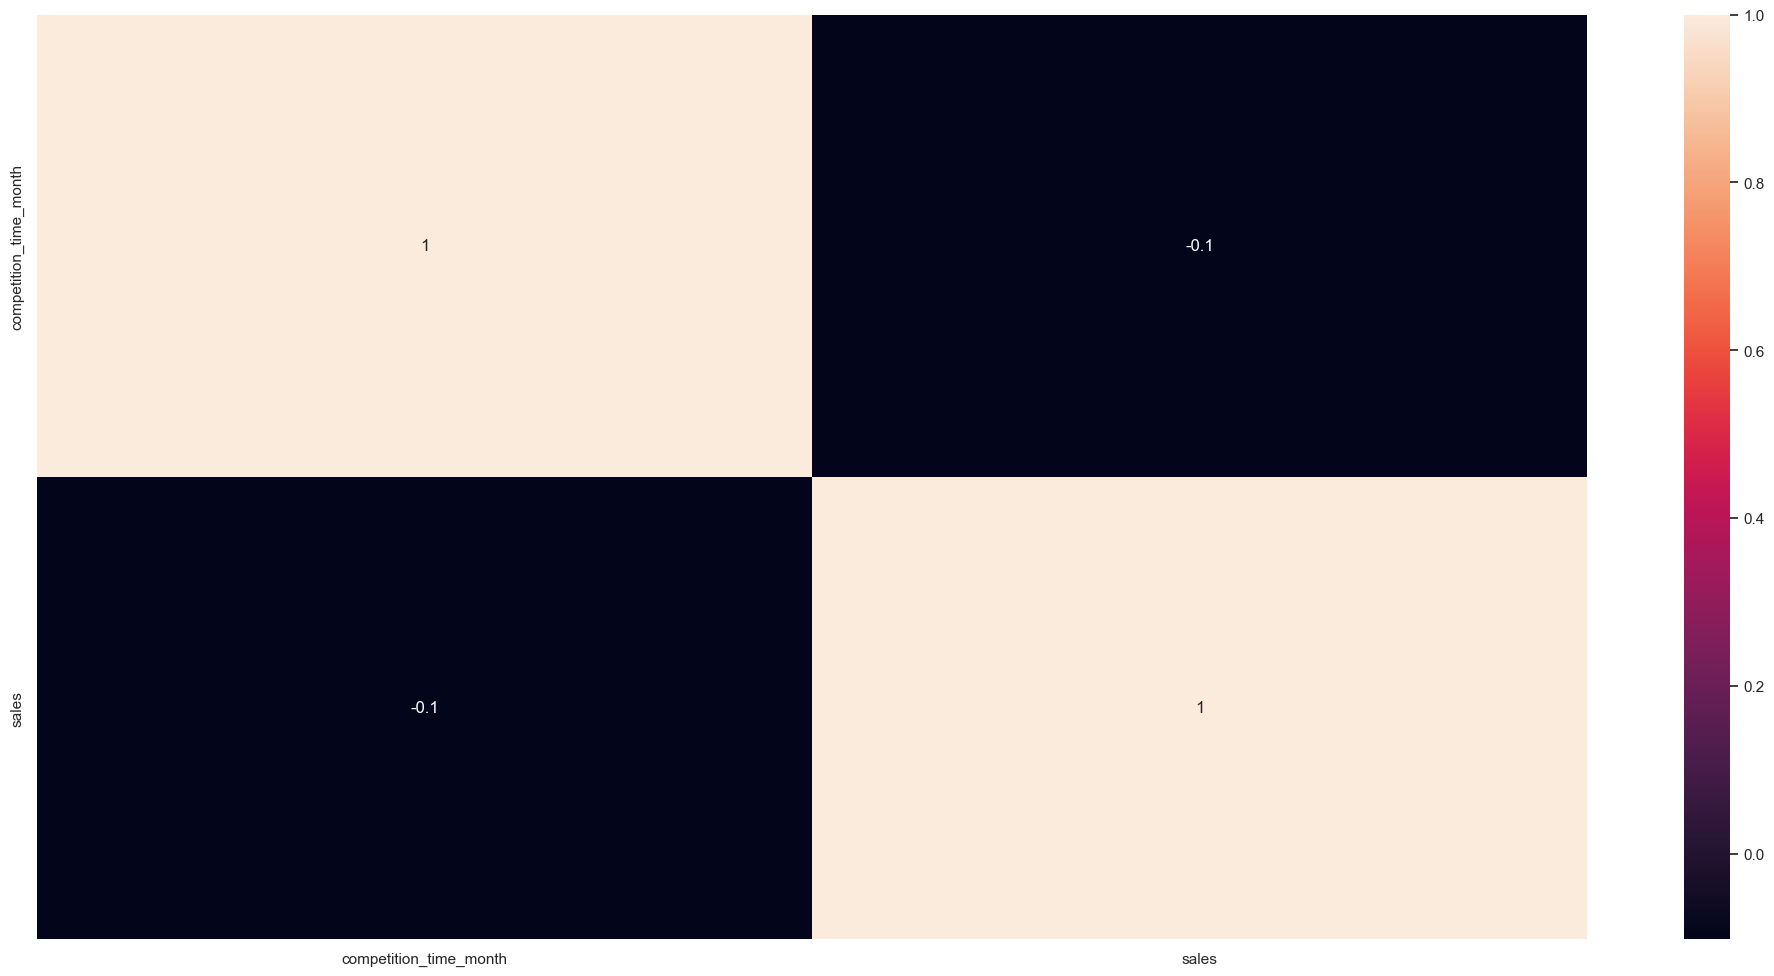

In [205]:

# Correlação
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );


### H4. Lojas com promoções ativas por mais tempo vendem MAIS
###### FALSA -> Lojas com promoções ativas por mais tempo vendem menos, depois de certo período de promoção

In [206]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

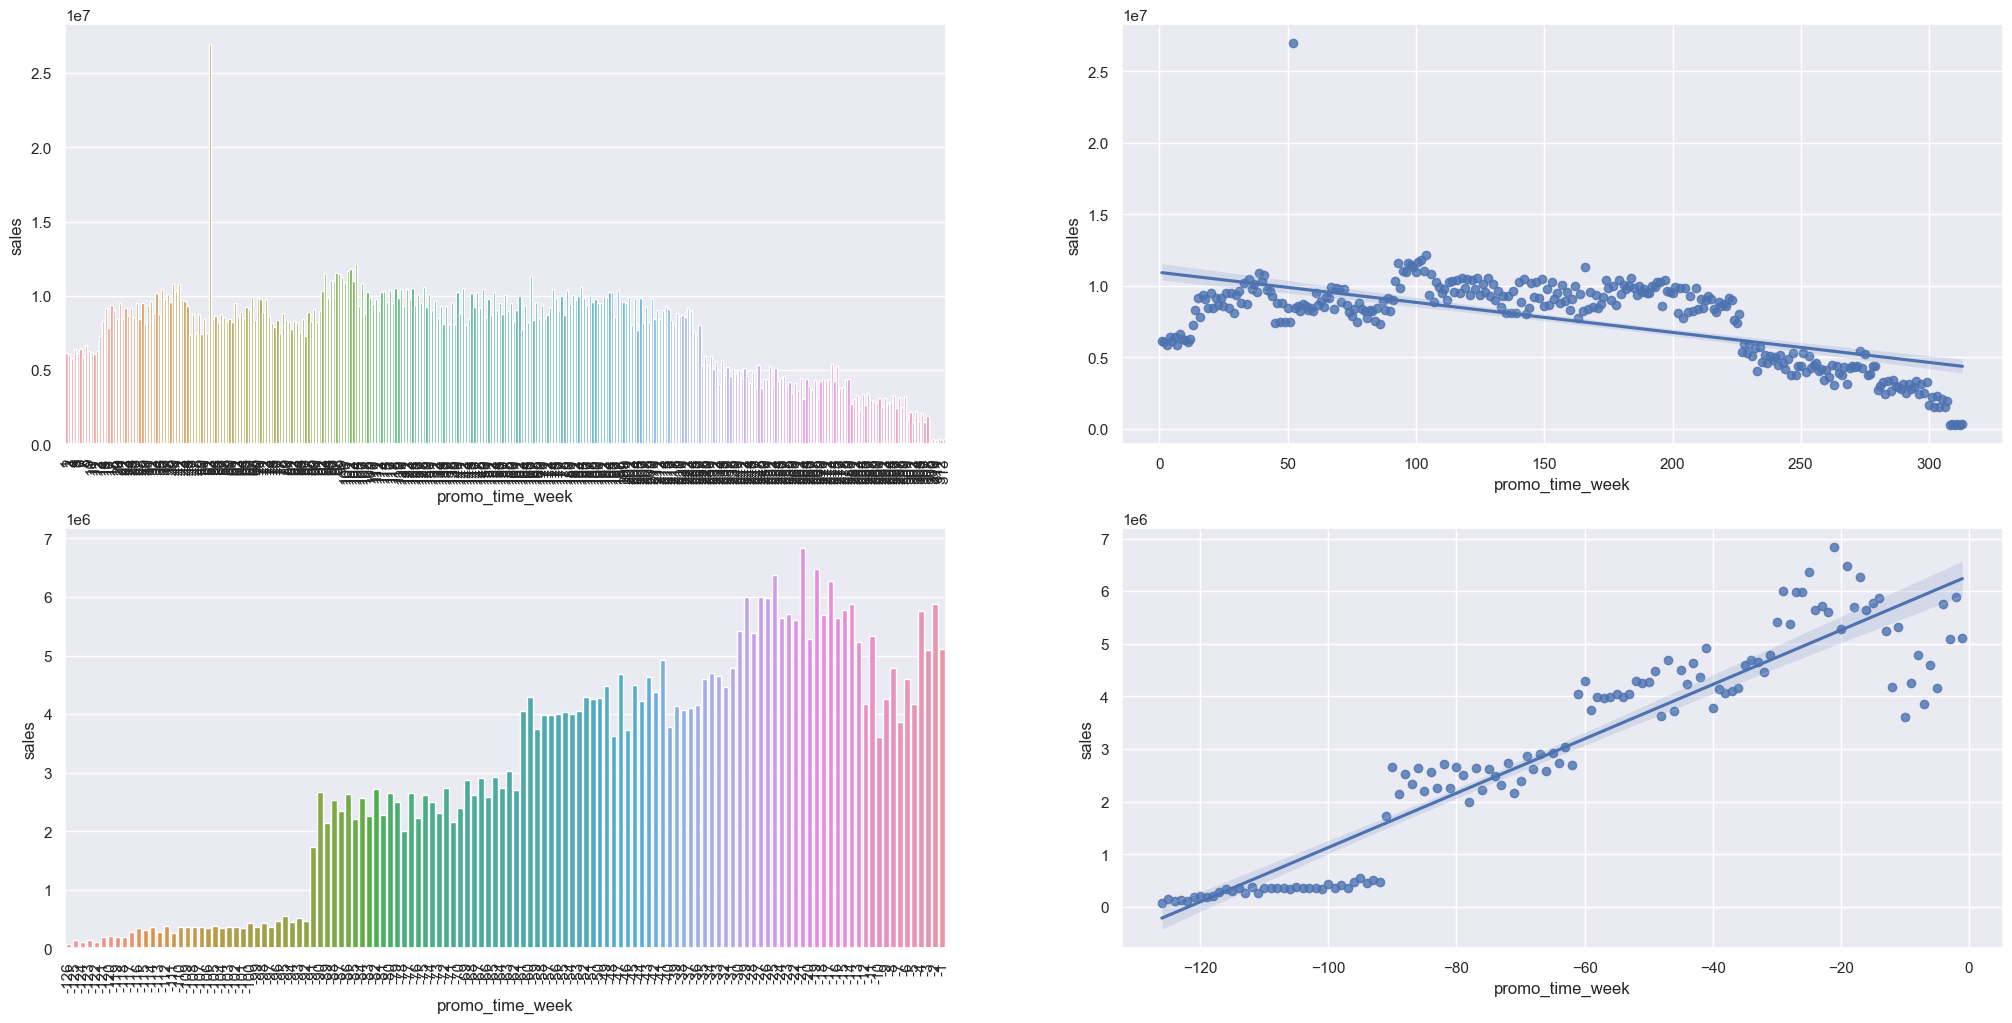

In [207]:
# Existem dois contextos - dois períodos de promoção: tradicional(Promo) e estendida (Promo2)
## Promo time week negativa, significa que a venda foi feita no período tradicional de promoções
## Promo time week positiva, significa que a venda foi realizada na promoção estendida
## A promoção estendida funciona até um período, depois começa a cair (então, promoção muito longa não funciona)
## Para o modelo nunca pode passar o dataset dividido em aux1 e aux2 (feature promo_time_week), a divisão só serve para enxergar mesmo os gráficos. 

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='sales', data=aux1);

# Separando as promoções: tradicional e estendida
plt.subplot(2,2,1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promo estendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(2,2,2)
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot(2,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0] # promo tradicional
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot(2,2,4)
sns.regplot( x='promo_time_week', y='sales', data=aux3 );


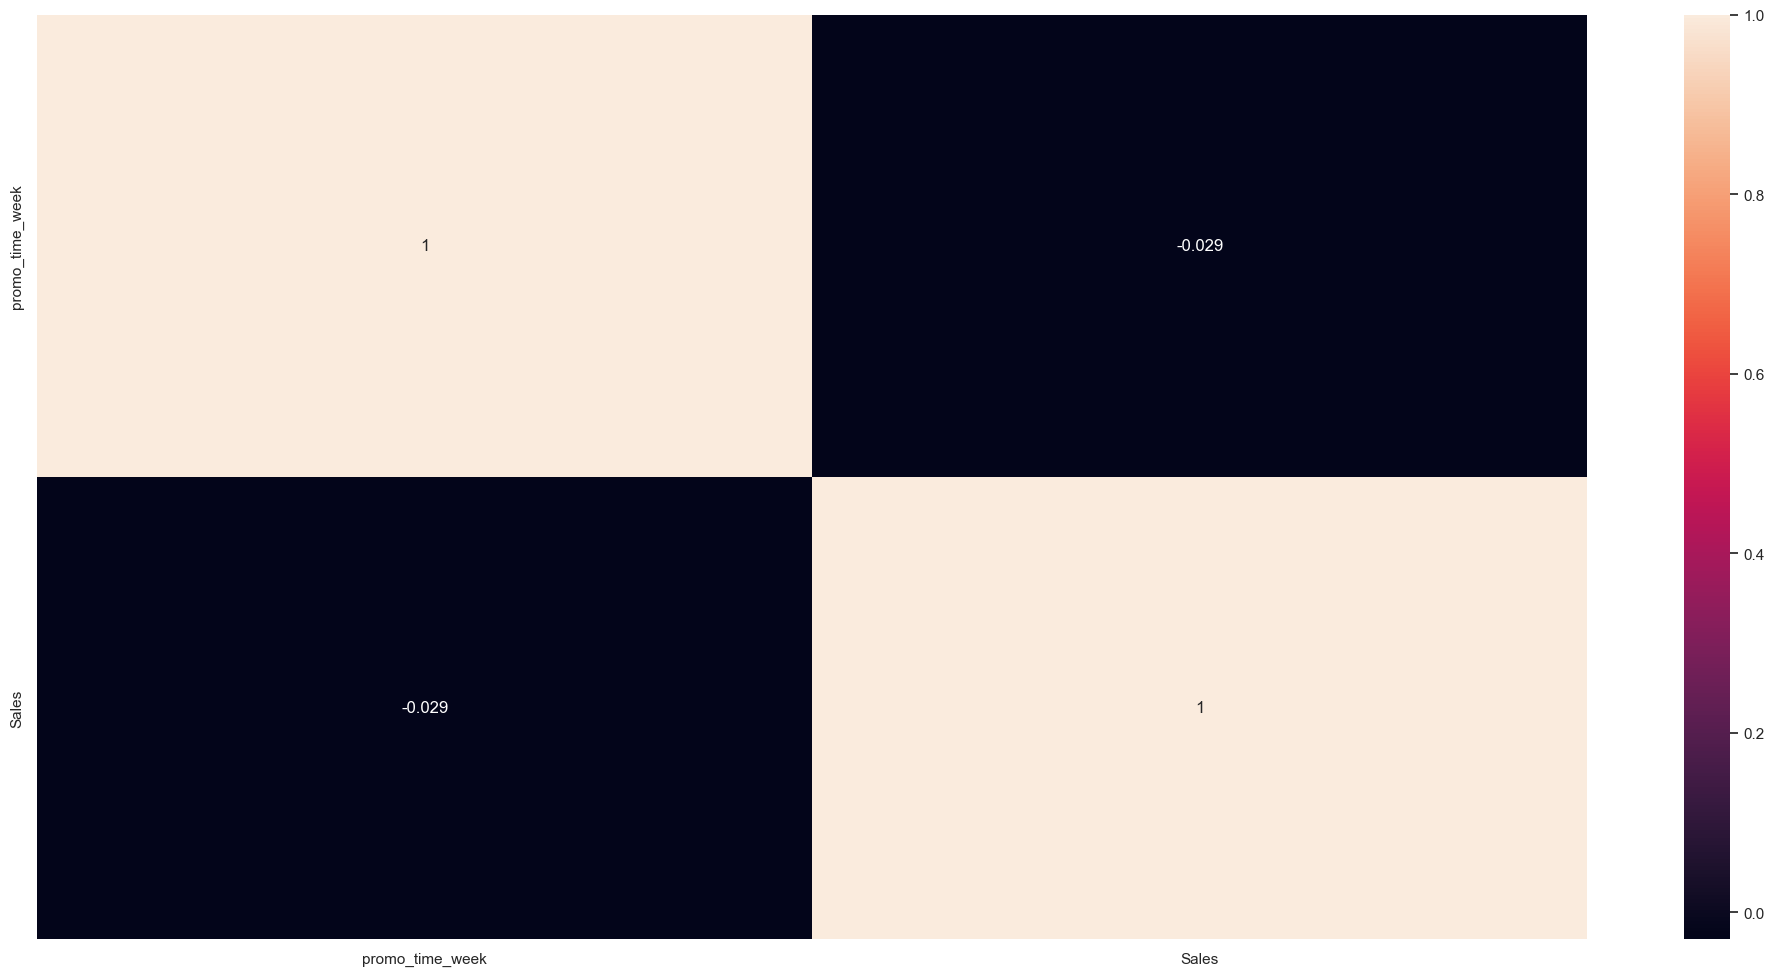

In [41]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H7. Lojas com promoções mais consecutivas vendem MAIS
###### FALSA -> Lojas com promoções mais consecutivas vendem menos

In [208]:
## Lojas que participaram apenas de uma promoção, venderam mais (2)
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


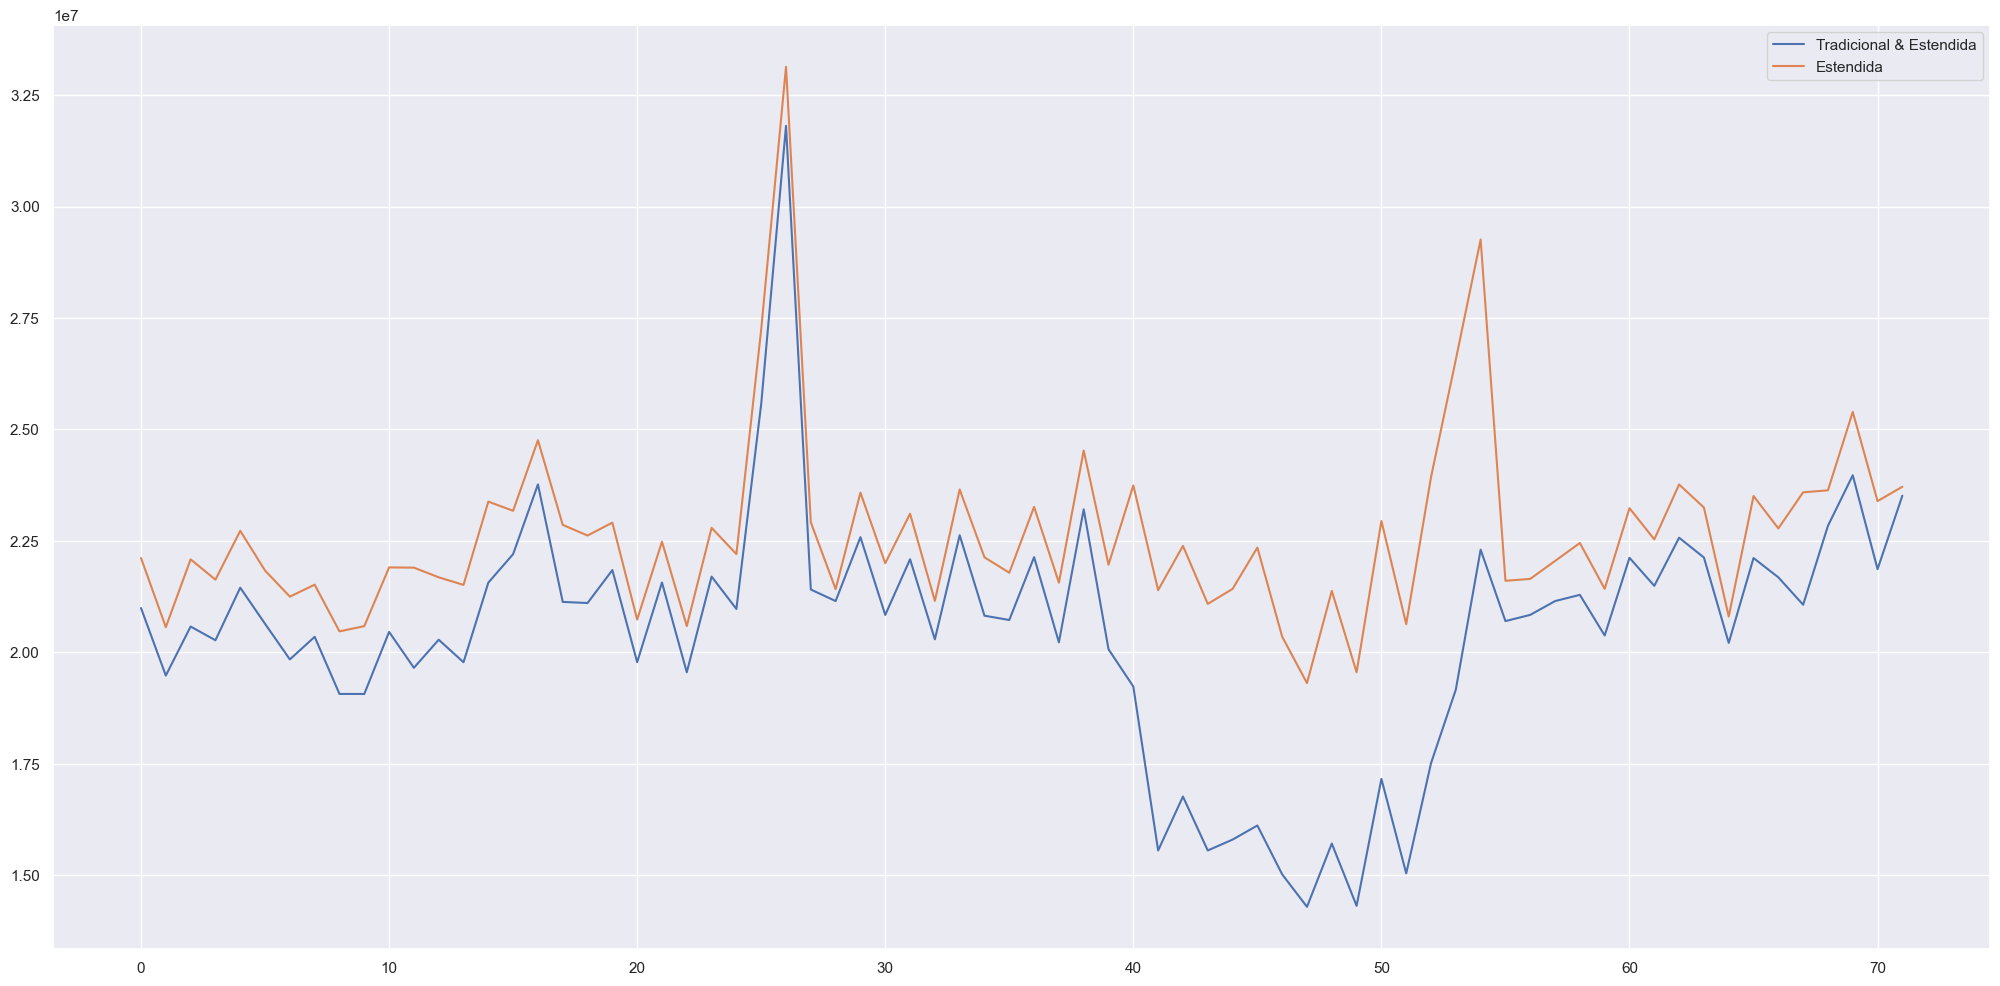

In [209]:
# Filtro 1: todas as lojas que participaram da promoção tradicional e estenderam a promoção (ao longo do tempo)
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# Filtro 2: todas as lojas que só participaram da Estendida
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Estendida', 'Estendida']);

### H8. Lojas abertas durante o feriado de Natal vendem MAIS
###### FALSA -> Lojas abertas durante o feriado de natal, vendem menos

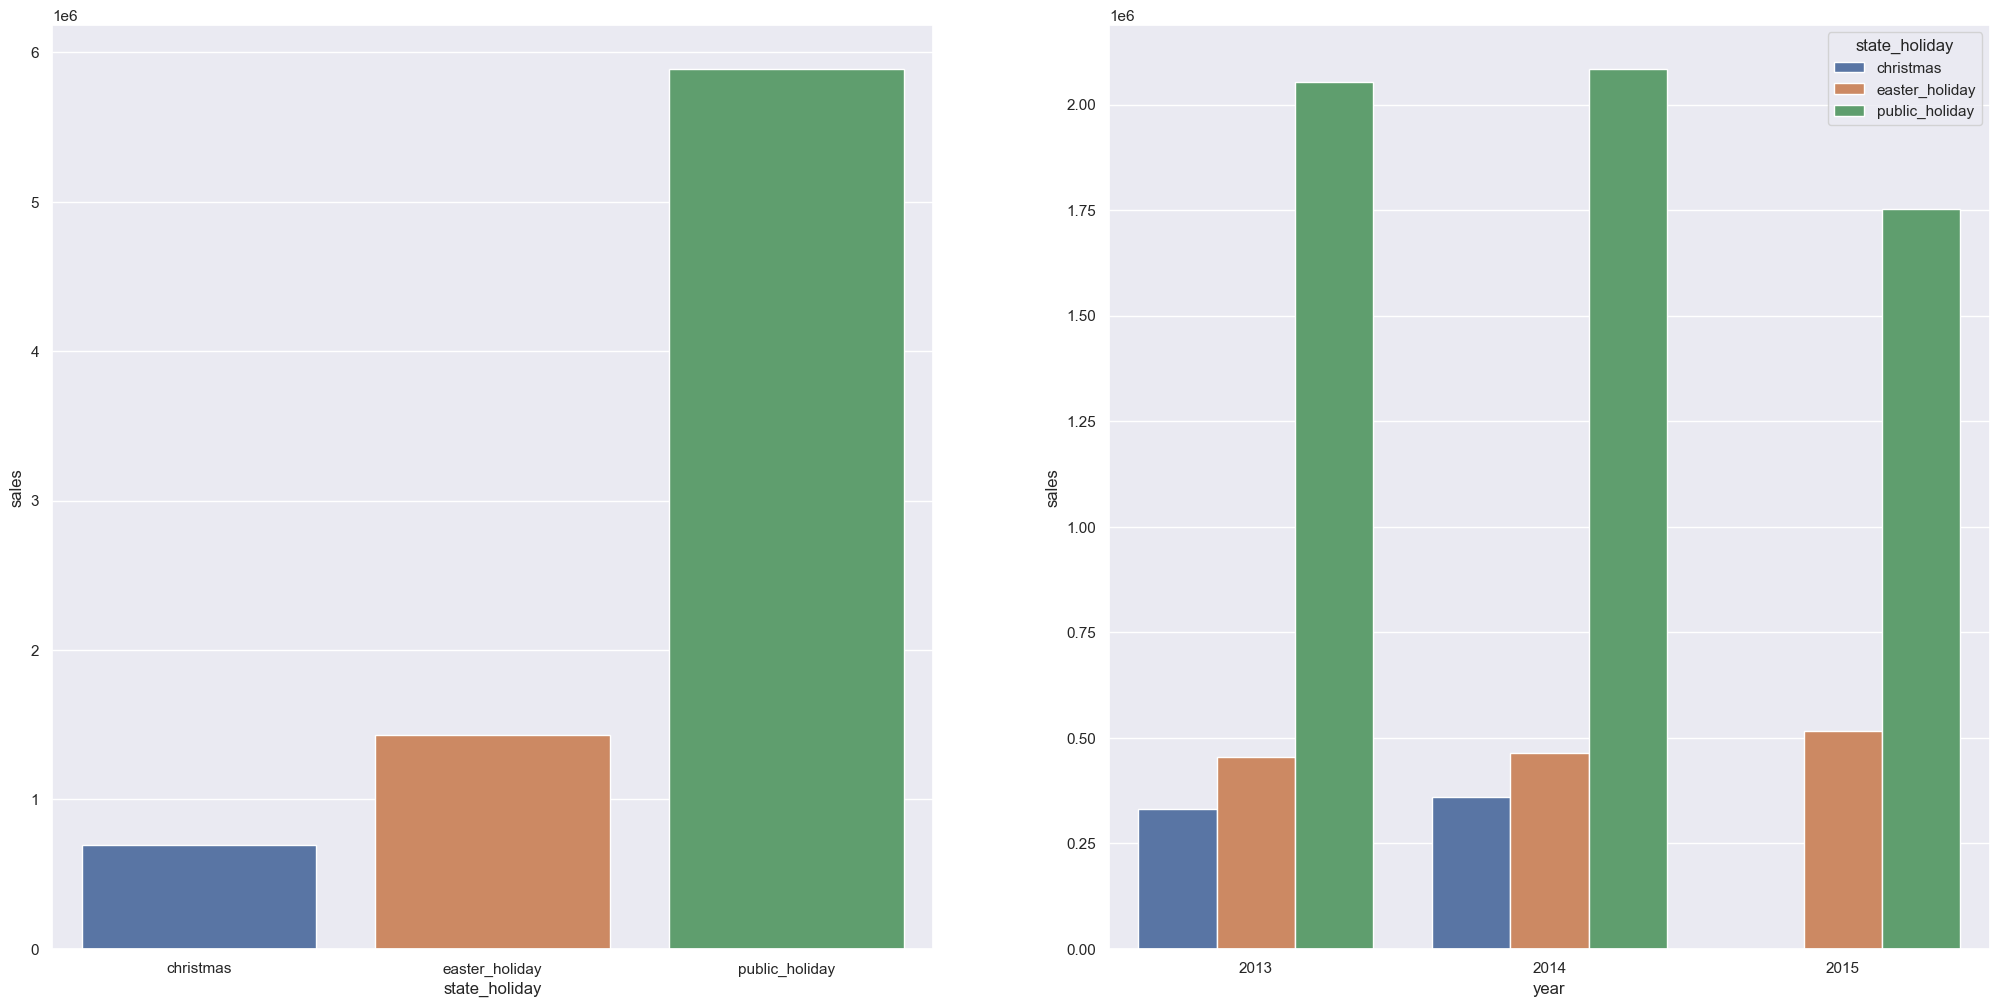

In [210]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

In [211]:
aux.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [212]:
df4.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### H9. Lojas deveriam vender mais ao longo dos anos
###### FALSA -> Lojas vendem menos ao longo dos anos

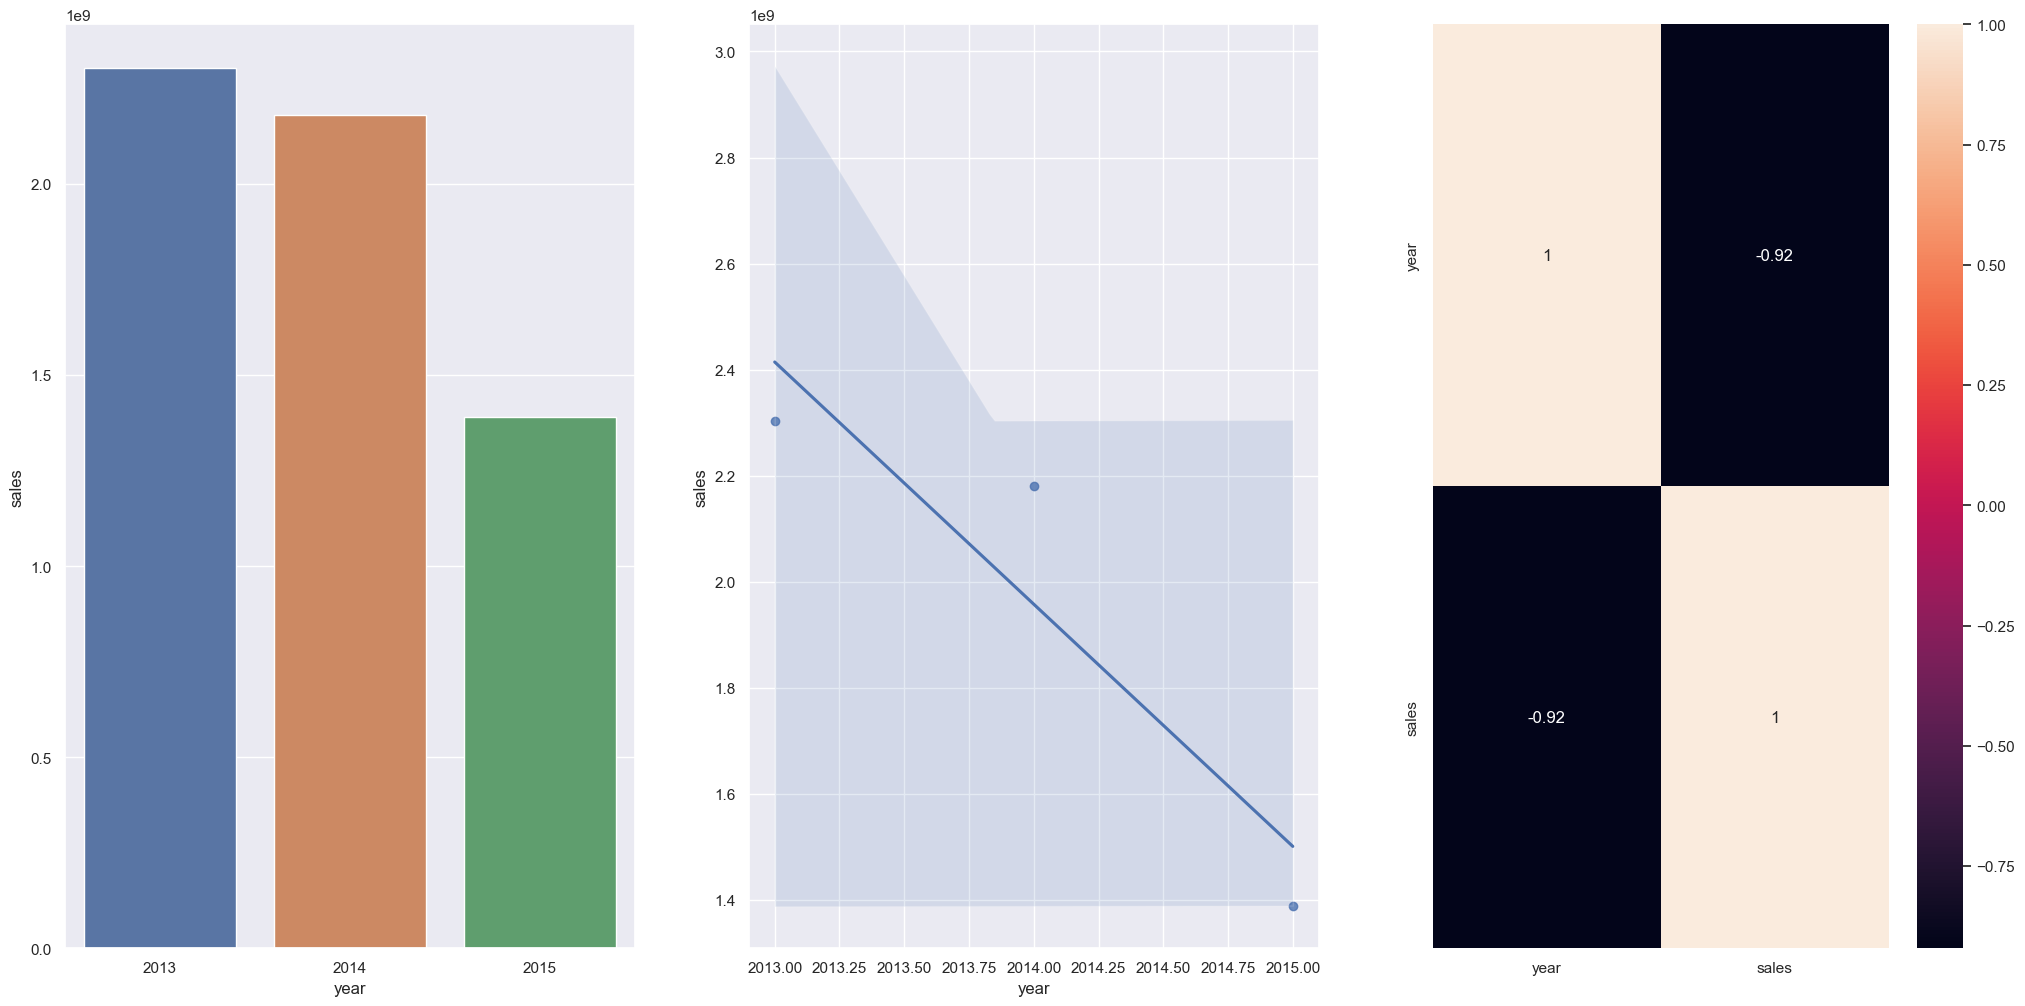

In [213]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

## Calculando a tendência
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 ); # tendência

## Calculando a correlação
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True ); # correlação (aumentam os anos e diminui as vendas)

# É preciso observar que a correlação é muito alta porque o ano de 2015 não está fechado, o ideal seria utilizar
# período fechado (como nesse caso 2015 ainda está em curso, ficaria de fora da análise)

### H10. Lojas deveriam vender mais no segundo semestre do ano 
###### FALSA ->  Lojas vendem menos no segundo semestre do ano

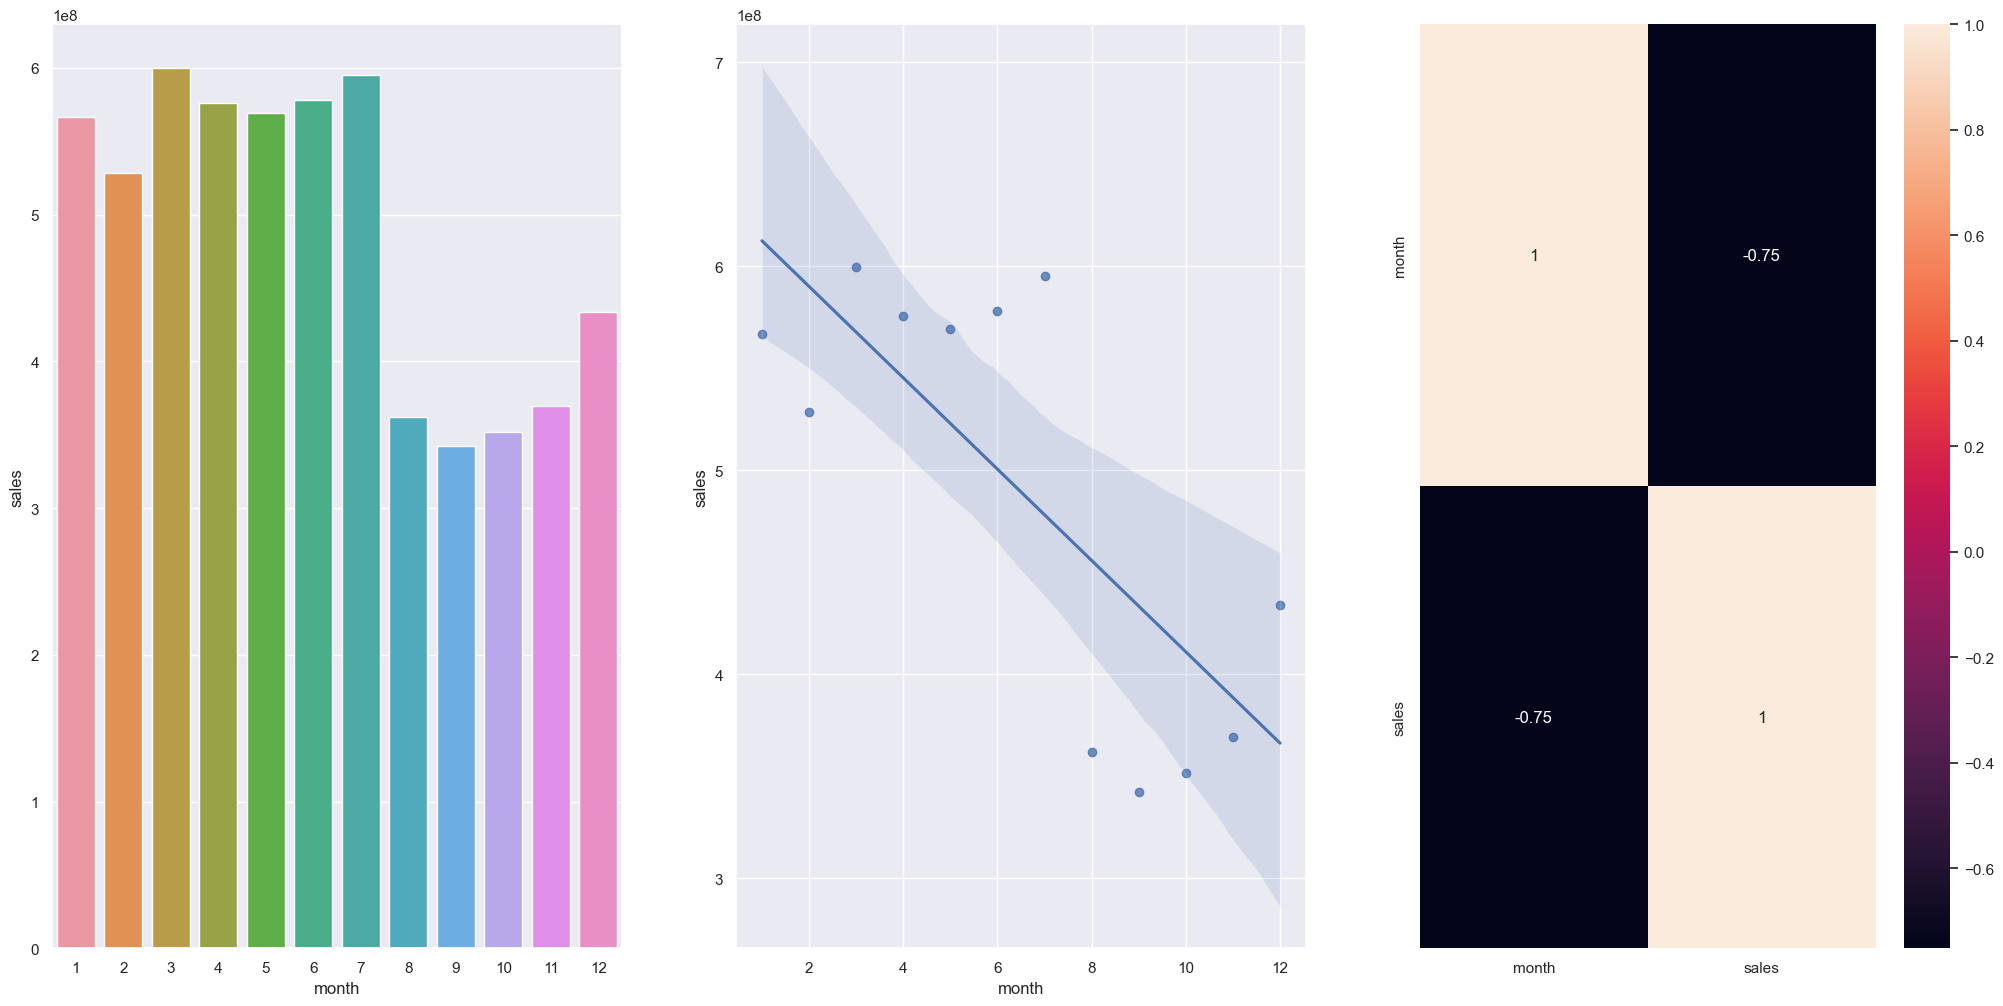

In [214]:
## As lojas da Rossmam vende menos no segundo semestre do ano
## Tanto a tendência, quando a correlação mostram isso com clareza
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês
###### VERDADEIRA ->  Lojas vendem mais depois do dia 10 de cada mês

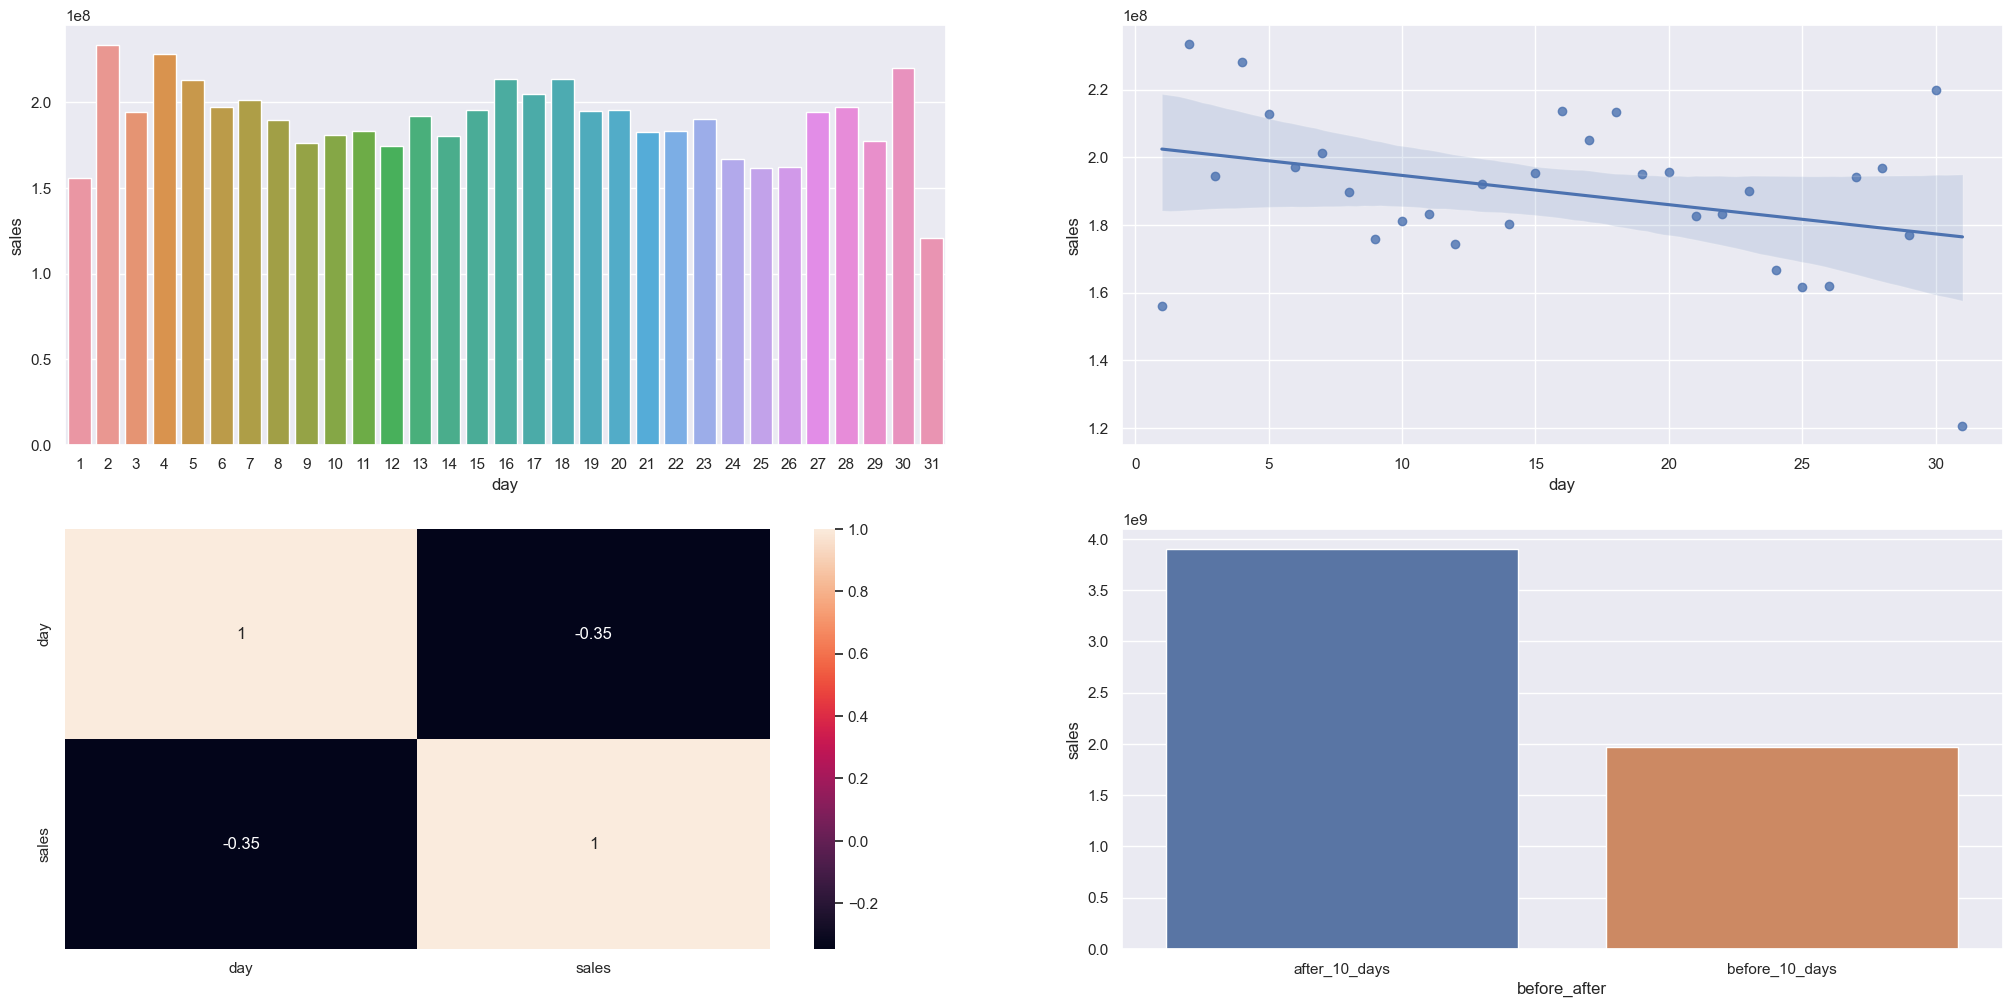

In [216]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#Agrupando os dias antes e depois do dia 10
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H12. Lojas deveriam vender menos nos finais de semana
###### VERDADEIRA ->  Lojas vendem menos nos finais de semana

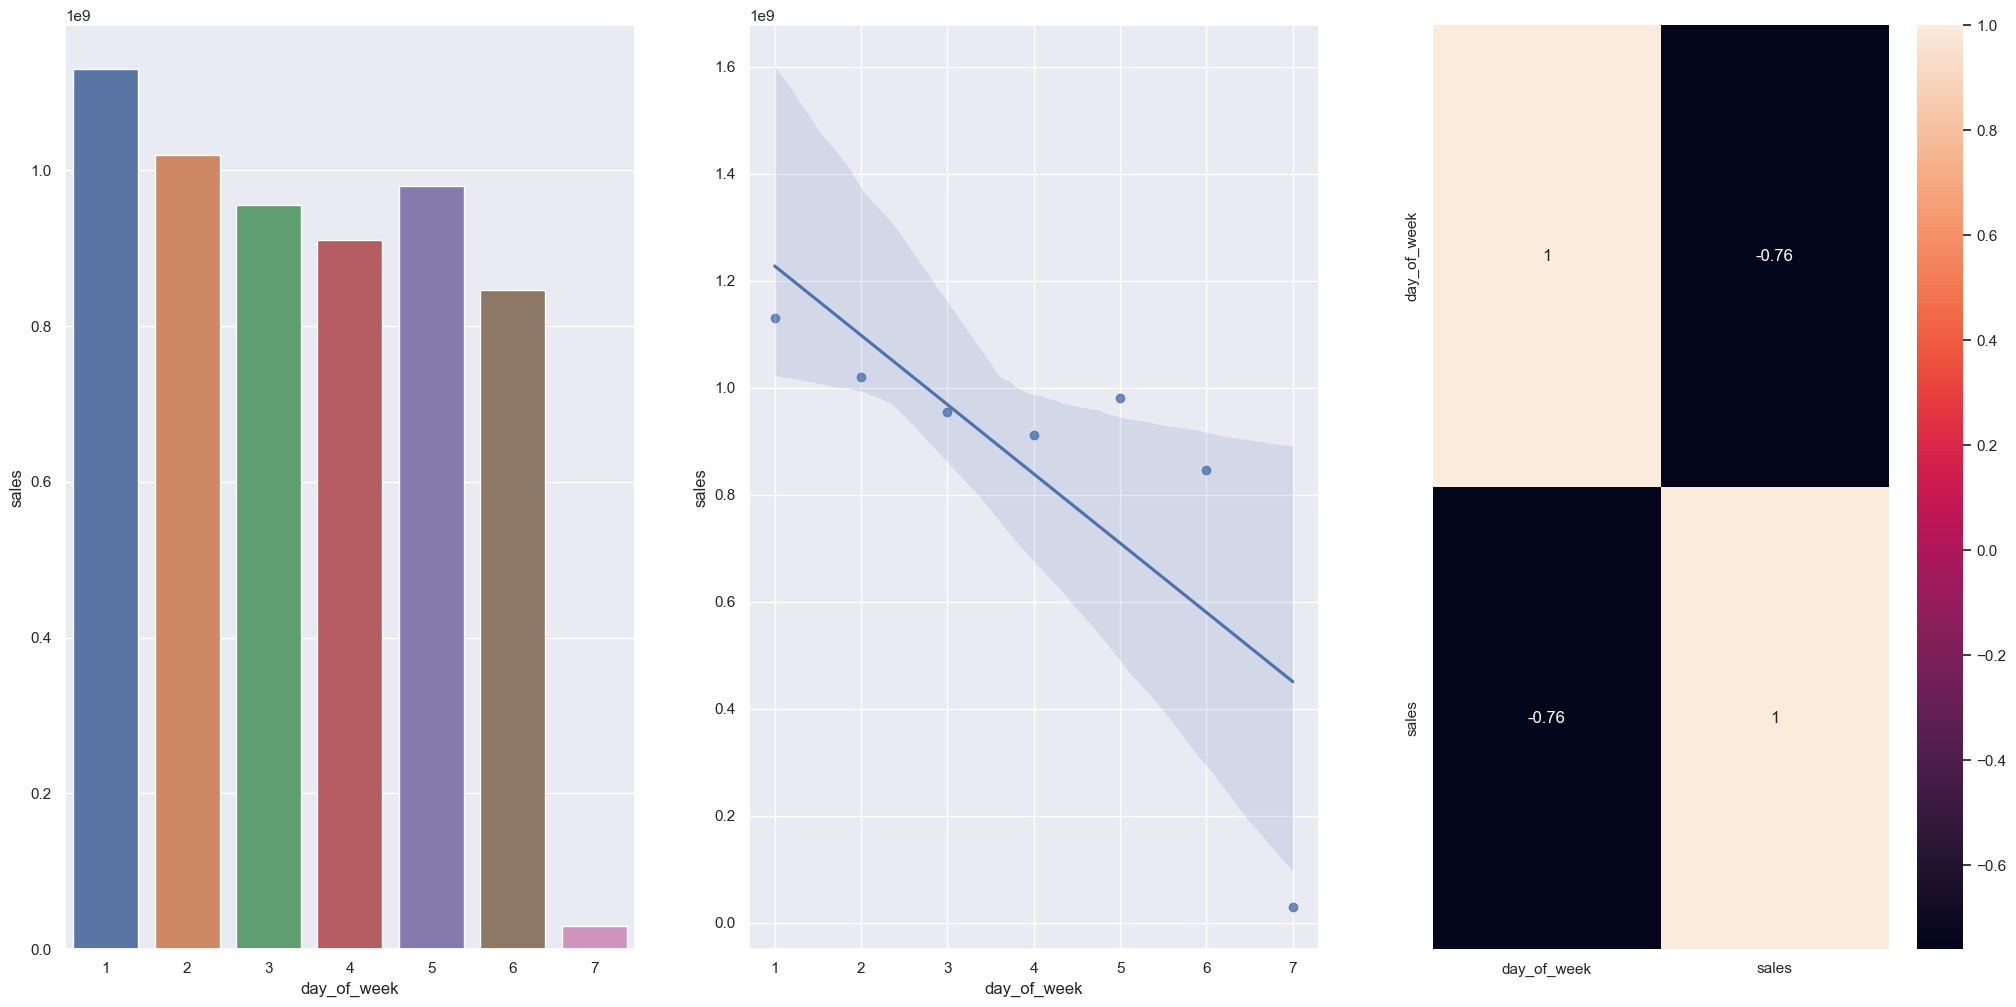

In [217]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H13. Lojas deveriam vender menos nos feriados escolares
###### VERDADEIRA ->  Lojas vendem menos nos feriados escolares, exceto nos meses de julho e agosto

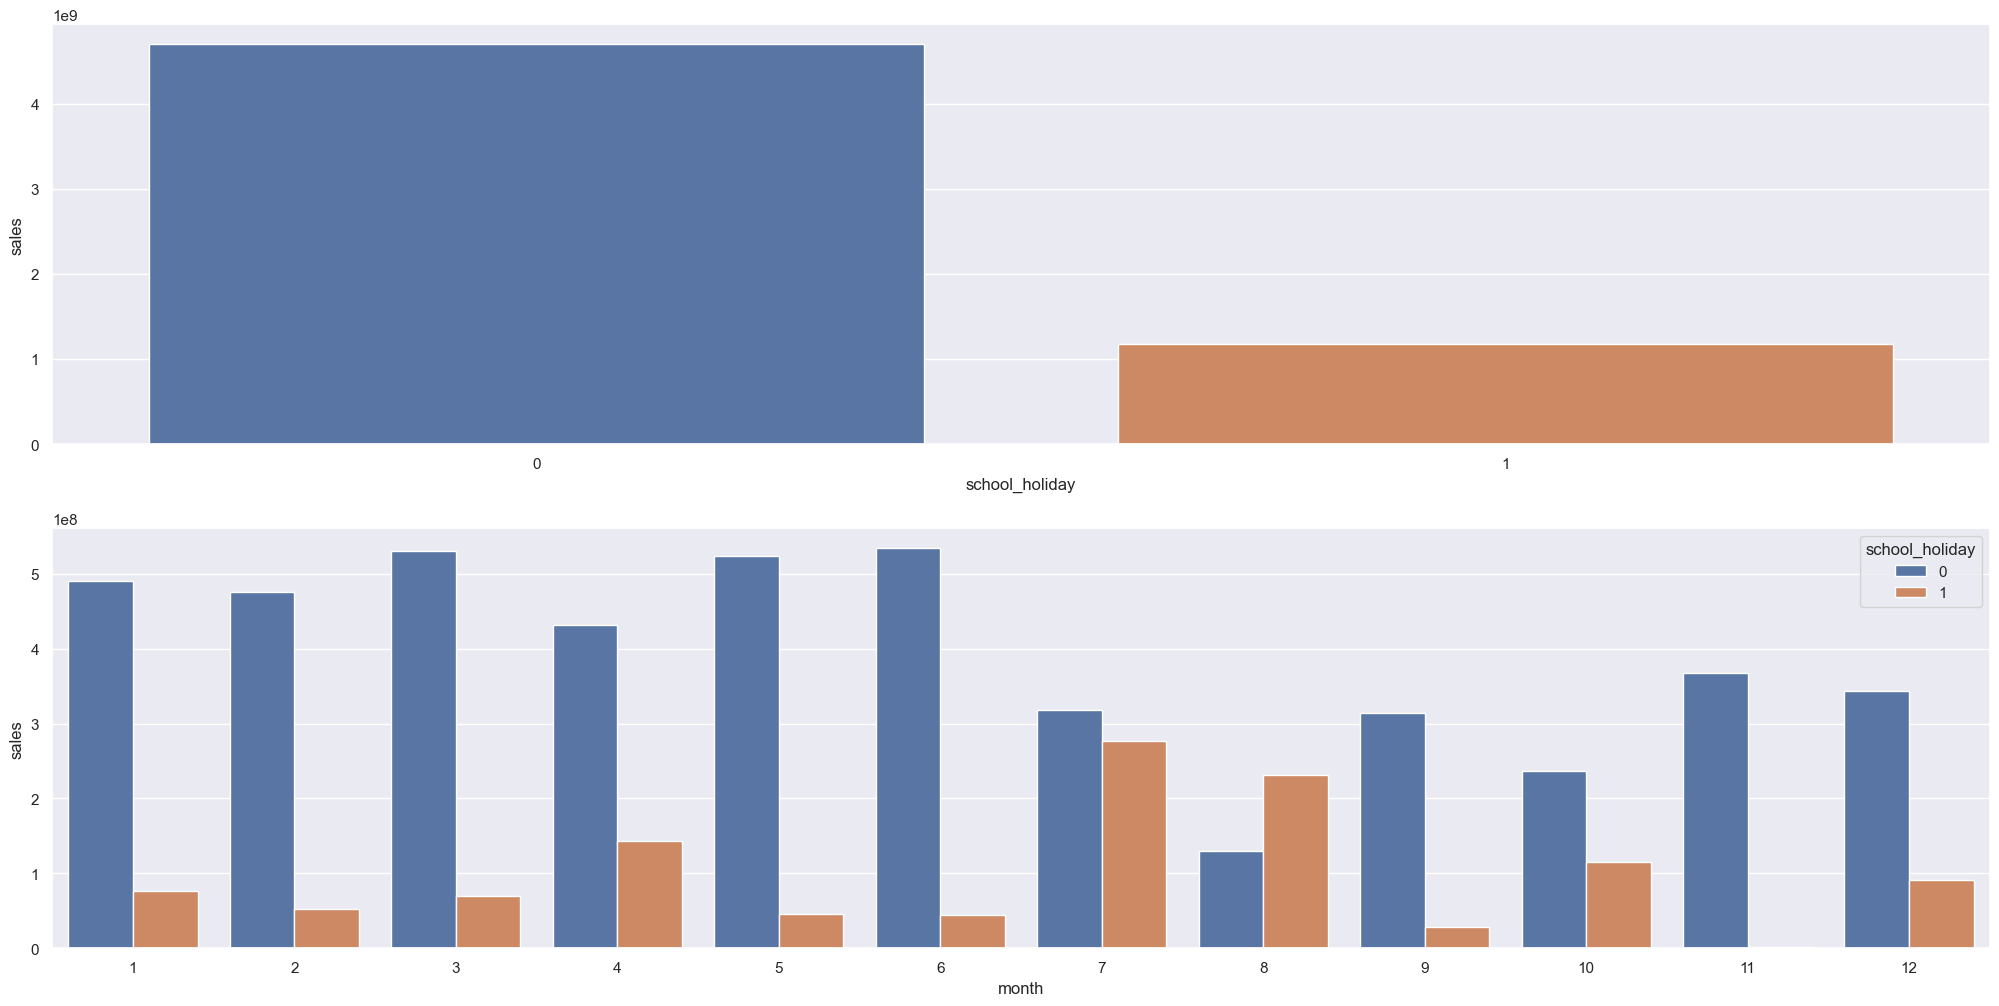

In [218]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1 Resumo das Hipóteses

In [219]:
## Exercício de expectativa da relevância das hipóteses
from tabulate import tabulate

In [220]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3 Análise MULTIVARIADA
##### Mostra quais variáveis são correlacionadas e cortá-las para a utilização do modelo menos complexo: porque generaliza melhor (com menos dimensionalidade dos dados) - Navalha de Ockham

### 4.3.1 Numerical Attributes

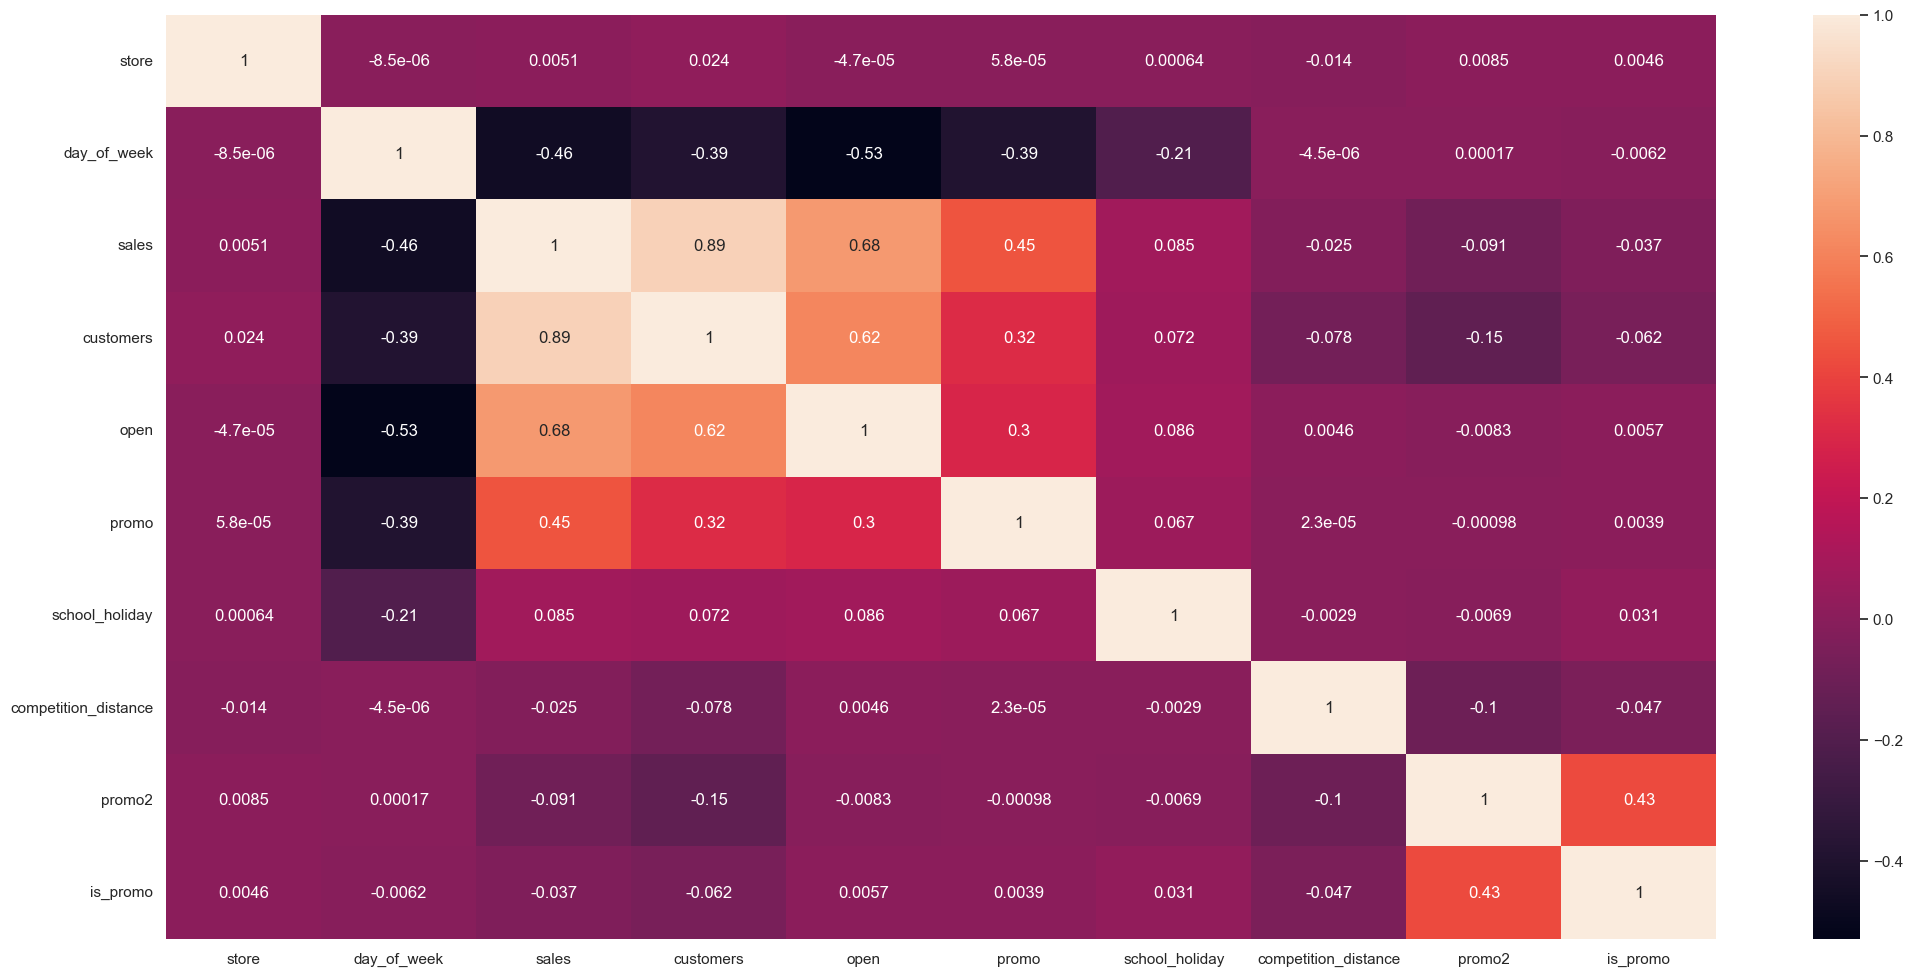

In [221]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

<AxesSubplot: >

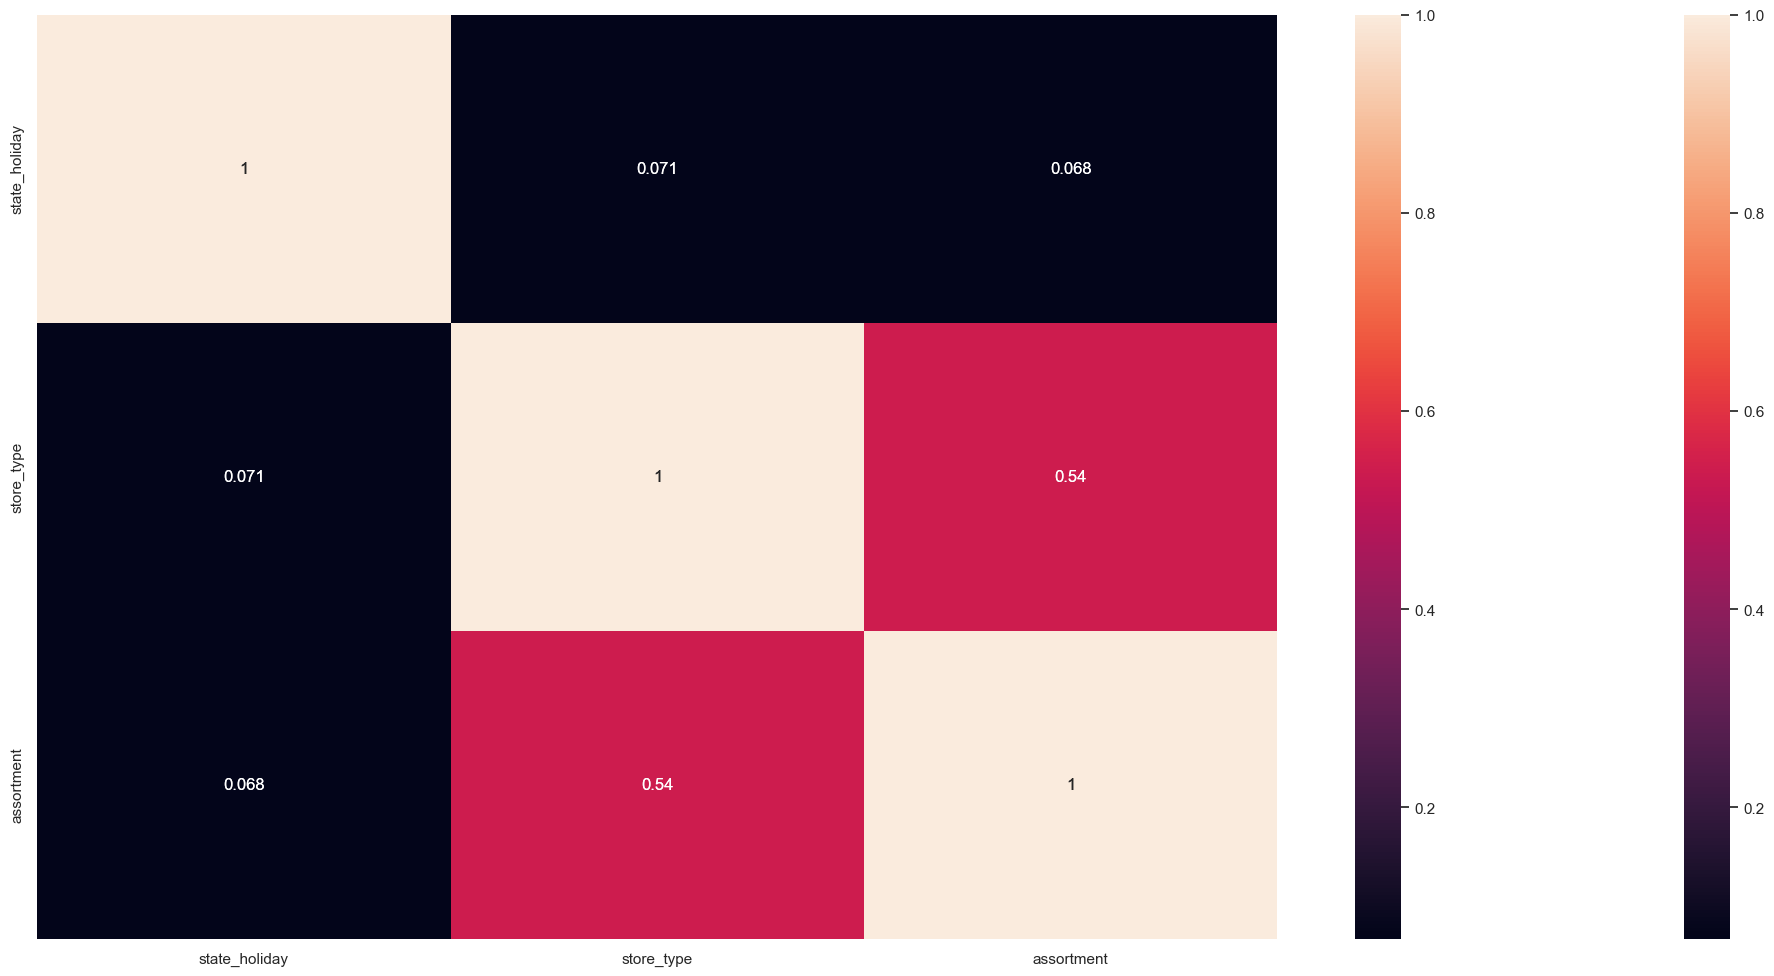

In [223]:
# Cramer v => Apenas para variáveis categóricas
# k é o numero de colunas e r é o numero de linhas)
# Matriz de confusão ou matriz de contingência (relaciona todas as linhas)
a = df4.select_dtypes( include='object' )

# Criando a matriz de confusão
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns ) # todas as colunas e linhas com nomes iguais

# correlações entre variáveis categóricas
sns.heatmap( d, annot=True )
a = df4.select_dtypes( include='object' )

# Cálculo cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Dataset final ("d" para colocar o nome das linhas igual das colunas)
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

In [69]:
# Nota:
# v de Cramer vai de zero a 1, só tem correlação positiva
# v = np.sqrt((chi2/n)/(min(k-1, r-1)))
# v

In [226]:
# Cálculo do Qui2 (cm=matriz de contingência) -> v de cramer (somente correlação positiva)
# Antes de colocvar na função
#cm = pd.crosstab(a['state_holiday'],['store_type'])as.matrix()
#from scipy import stats
#chi2 = ss.chi2_contingency(cm)[0]
#n =cm.sum()
#r,k = cm.shape
#v = np.sqrt((chi2/n)/(min(k-1,r-1)))
#v

## 5. DATA PREPARATION

In [227]:
df5 = df4.copy()

In [228]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')


### 5.1 Normalização

In [94]:
# Observar as variáveis na análise univariada (variáveis numéricas com distribuição normal)
# Observa-se que nenhuma das variáveis possui distribuição normal

### 5.2 Rescaling
###### Equalizar - colocar as variáveis na mesma escala (range) - é utilizado para variáveis que não tem distribuição normais
###### 1. Min-Max Scaler (sensível a outliers, porque usa máximo e mínimo)
###### 2. Robust scaler (não é sensível aos outliers, porque usa os quartis) 

In [229]:
## Rescaling para equalizar a escala
# aplica o boxplot para saber se tem outliers e escolher o método
# sns.boxplot(df['nome_da_coluna'])
# rs.fit_transform(encontra os quartis e aplica a fórmula)

rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
## fit.transform (encontra os parâmetros da fórmula e aplica nos dados)
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )
# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )
# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )
# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

<AxesSubplot: xlabel='competition_distance', ylabel='Density'>

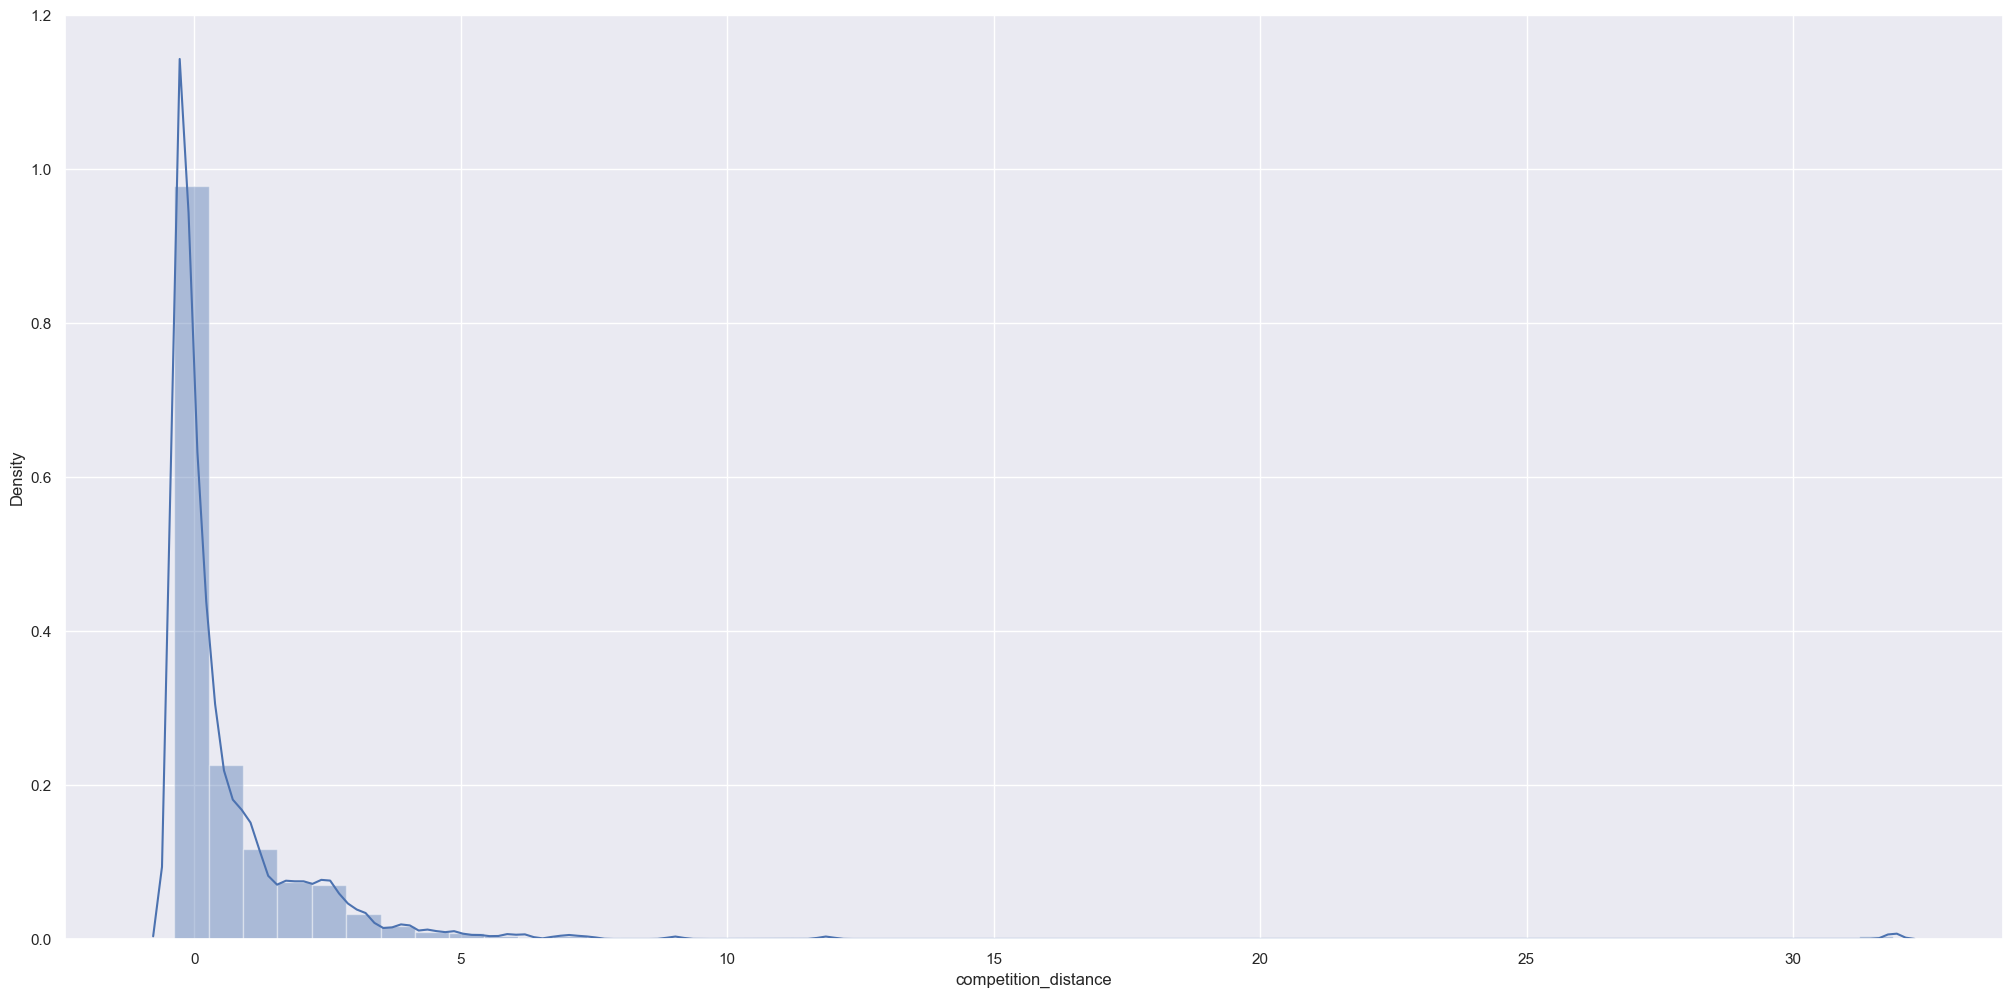

In [230]:
sns.distplot(df5['competition_distance'])

### 5.3 Transformação

### 5.3.1 Encoding

In [231]:
# Converter a variável categórica em uma variável numérica, mantendo o conteúdo de informação
# State Holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
                     
# Store type - Label encoding (trocou as letras a, b, c por numeros)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))  
                     
# Assortment - Ordinal Encoding (tem uma ordem) - substitui basic por 1, extra por 2, extended por 3
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

<AxesSubplot: xlabel='sales', ylabel='Density'>

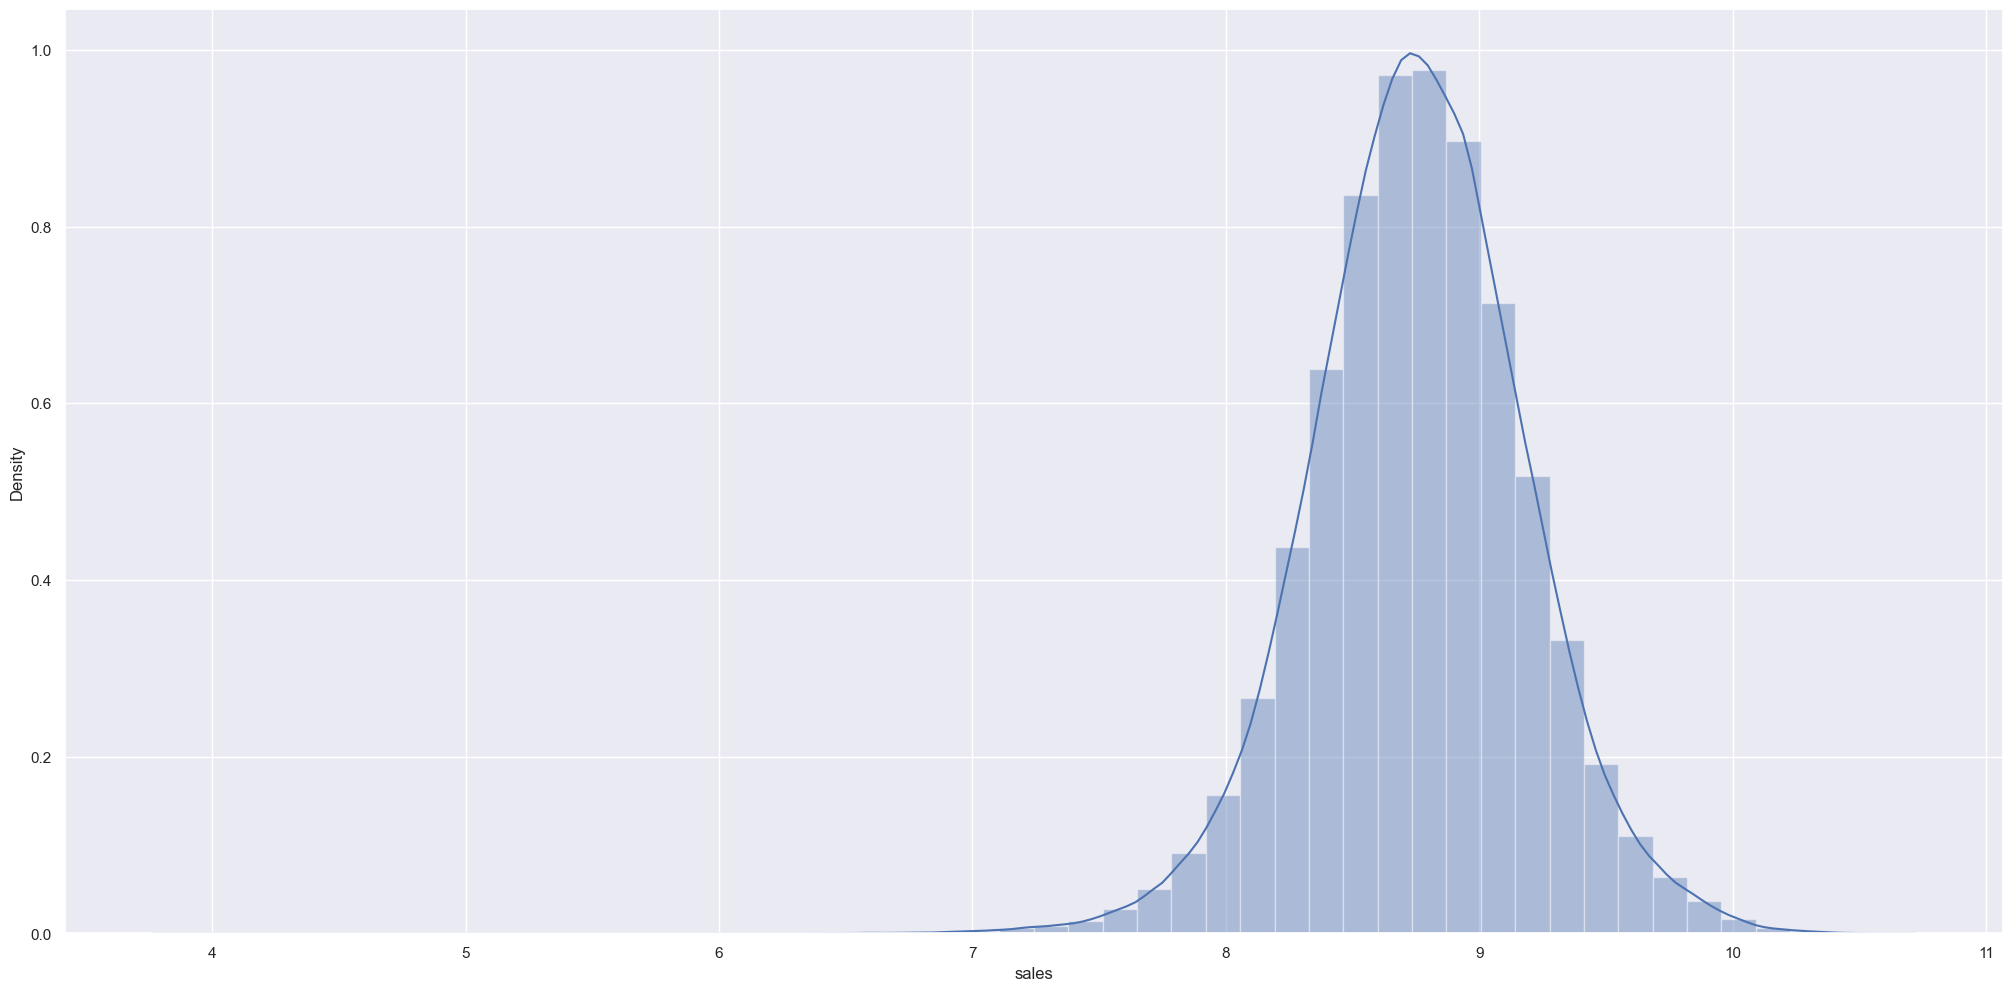

In [ ]:
# Transformação logaritmica (método da classe numpy): Variável resposta = Sales
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation   

In [233]:
# Variáveis que vão trocar de natureza (datas)
# Day of week
df5['DayOfWeek_Sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['DayOfWeek_Cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. *np.pi/7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. *np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. *np.pi/12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. *np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. *np.pi/30)))

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. *np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. *np.pi/52)))

In [234]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,DayOfWeek_Sin,DayOfWeek_Cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.0 Passo 6 - FEATURE SELECTION

In [235]:
df6=df5.copy()

## Quais variáveis são mais importantes segundo o Boruta?

### 6.1 Split dataframe into training and test dataset

In [236]:
# Deletando as variáveis que são originais e derivaram novas variáveis
cols_drop = ['week_of_year', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [237]:
df6[['store', 'date']].groupby('store').min().reset_index() # data mínima
df6[['store', 'date']].groupby('store').max().reset_index() # data máxima
df6[['store', 'date']].groupby('store').min().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2012-11-21 00:00:00')

In [238]:
## Separar os dados em treino e teste
#Como a ideia é fazer uma previsão das vendas nas 6 semanas futuras, o split de treino e teste é feito de forma temporal
# e não aleatória
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
                                                                                         
print('\nTest Min Date: {}'.format(X_train['date'].min()))
print('Test Max Date: {}'.format(X_train['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2013-01-01 00:00:00
Test Max Date: 2015-06-18 00:00:00


### 6.2 Boruta as Feature Selector

In [110]:
## Treino e teste  com  Boruta + Random Forest
# Import

#X_train_n = X_train.drop(['Date','Sales'], axis=1).values      ###values pega só os valores ("miolo do dataset")
#y_train_n = y_train.values.ravel()    ###ravel coloca dentro de um vetor
#
## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)       #n_jobs=-1 cria as árvores em paralelo(mais rápido)
#
##define Boruta

#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)
#não é possível passar um dataframe, é preciso que seja um vetor numpy

# Nota sobre os parâmetros:
#n_estimators=auto (o Boruta escolhe o nº de árvores); verbose=2 (printa o que está fazendo);
# random_state=42(parta do mesmo início->início da aleatoriedade)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [245]:
cols_selected = boruta.support_.tolist()
#
## best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()
#
## not selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

NameError: name 'boruta' is not defined

### 6.3 Manual Feature Selection

In [246]:
cols_selected_boruta = [
    'store', 
    'promo', 
    'store_type', 
    'assortment',
    'competition_distance',
    'competition_open_since_month', 
    'competition_open_since_year', 
    'promo2',
    'promo2_since_week', 
    'promo2_since_year', 
    'competition_time_month',
    'promo_time_week',
    'DayOfWeek_Sin', 
    'DayOfWeek_Cos', 
    'month_sin', 
    'month_cos', 
    'day_sin',
    'day_cos', 
    'week_of_year_sin', 
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

## 7. PASSO 7 - MACHINE LEARNING MODELLLING

In [247]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

### 7.1 Average Model

In [248]:
x_test.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'DayOfWeek_Sin', 'DayOfWeek_Cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [249]:
## yhat = predição

aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average_model', np.expm1(Y_test), np.expm1(yhat_baseline)) #utiliza expm1 para sair do log
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average_model,1354.800353,0.455051,1835.135542


### 7.2 Linear Regression Model 

In [250]:
# A regressão linear teve um erro maior que a média (baseline), isso significa que o modelo é pior que a média
# e que os dados são complexos e não não possuem um comportamento linear.
# As próximas tentativas devem ser em modelos não lineares
# Model
lr = LinearRegression().fit(x_train, Y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 Linear Regression Model - Cross Validation

In [253]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


### 7.3 Linear Regression Regularized Model - Lasso

In [254]:
# Modelo linear - performou mal
# Model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)  ##alpha=fator multiplicativo do peso para que fique dentro de um range

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.3.1 Lasso - Cross Validation

In [255]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


### 7.4 Random Forest Regressor

In [256]:
## Modelos não lineares
# Model (n_jobs=-1: para rodar em paralelo e ser mais rápido)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


#### 7.4.1 Random Forest Regressor - Cross Validation

In [257]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61+/-217.1,0.12+/-0.02,1254.3+/-316.17


### 7.5 XGBoost Regressor

In [113]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.3,
                             max_depth=6,
                             subsample=1,
                             colsample_bytree=1).fit(x_train, Y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result
                      

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


#### 7.5.1  XGBoost Regressor - Cross Validation

In [114]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.94+/-178.65,0.15+/-0.02,1519.92+/-242.12


### 7.6 Compare Model's Performance

#### 7.6.1 Single Performance

In [258]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average_model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.6.2 Real Performance - Cross Validation 

In [259]:
modelling_result_cv = pd.concat([ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,836.61+/-217.1,0.12+/-0.02,1254.3+/-316.17
0,XGBoost Regressor,1064.94+/-178.65,0.15+/-0.02,1519.92+/-242.12


## 8. Passo 8 - Hiperparameter Fine Tuning

### 8.1 Random Search

In [138]:
# Não rodar de novo
param = {
    'n_estimators': [1500,1700,2500,3000,3500],
    'eta': [0.01, 0.03],
    'max_depth':[3,5,9],
    'subsample': [0.1,0.5,0.7],
    'colsample_bytree':[0.3,0.7,0.9],
    'min_child_weight':[3,8,15]
}

MAX_EVAL = 5

In [142]:
import numpy.random

In [144]:
from numpy import random

In [148]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample(v,1)[0] for k, v in param.items() }
    print( hp )

    ## model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                n_estimators=hp['n_estimators'], 
                                eta=hp['eta'], 
                                max_depth=hp['max_depth'], 
                                subsample=hp['subsample'],
                                colsample_bytee=hp['colsample_bytree'],
                                min_child_weight=hp['min_child_weight'] )

## performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
      
final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5
[09:52:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 4
[10:00:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 3
[10:09:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 2
[10:18:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not u

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1232.0+/-120.51,0.17+/-0.01,1781.91+/-150.64
0,XGBoost Regressor,924.69+/-126.55,0.13+/-0.01,1317.12+/-169.83
0,XGBoost Regressor,1063.58+/-122.31,0.15+/-0.01,1530.7+/-159.58
0,XGBoost Regressor,1252.66+/-143.4,0.17+/-0.01,1805.74+/-176.45
0,XGBoost Regressor,1588.27+/-157.13,0.22+/-0.01,2292.76+/-204.6


### 8.2 Final Model

In [260]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth':5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [261]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, Y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,770.209978,0.115623,1108.062869


In [ ]:
# Comparando erro com o cálculo do MAPE

In [151]:
np.expm1(y_test).min()

569.0000000000002

In [152]:
np.expm1(y_test).max()

41550.99999999998

In [153]:
 np.expm1(y_test).max() - np.expm1(y_test).min()

40981.99999999998

In [154]:
 np.expm1(y_test).mean()

6995.162576094309

In [155]:
# Para calcular em percentual: erro MAE/média (fecha 10% de erro): MAE
665/6695

0.09932785660941

In [156]:
# RMSE: media 9958, equivale a 15%
956/6695


0.14279312920089618

In [262]:
# MPE (calcula na hora de entregar o modelo final): resultado -0.003 (
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1( yhat_xgb_tuned))
mpe


-0.01598888634252218

In [ ]:
# não rodar de novo os hiperaparâmetros e o boruta ( comenta-se para não rodar de novo, salva). Usa uma vez a cda crisp
# Colocar o pikle

## 9. Passo 9 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [263]:
df9 = X_test[cols_selected_boruta_full]

#rescale (voltar para a escala original)
df9['sales'] = np.expm1(df9['sales'])
df9['predictions']=np.expm1(yhat_xgb_tuned)

### 9.1 Business Performance

In [264]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios - Melhor e pior cenário 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [265]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
475,476,217441.468750,216864.911436,218018.026064,576.557314,0.135794
88,89,236009.765625,235462.712706,236556.818544,547.052919,0.093379
613,614,240484.234375,239744.851972,241223.616778,739.382403,0.111674
792,793,177310.734375,176743.780933,177877.687817,566.953442,0.113686


In [266]:
# Como saber quais lojas estão com a previsão pior:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107259.992188,103900.995760,110618.988615,3358.996428,0.588526
908,909,218136.984375,210139.046769,226134.921981,7997.937606,0.523377
169,170,210068.781250,208498.057327,211639.505173,1570.723923,0.388486
901,902,202738.703125,201256.792243,204220.614007,1481.910882,0.369999
875,876,196581.156250,192483.555006,200678.757494,4097.601244,0.338941


<AxesSubplot: xlabel='store', ylabel='MAPE'>

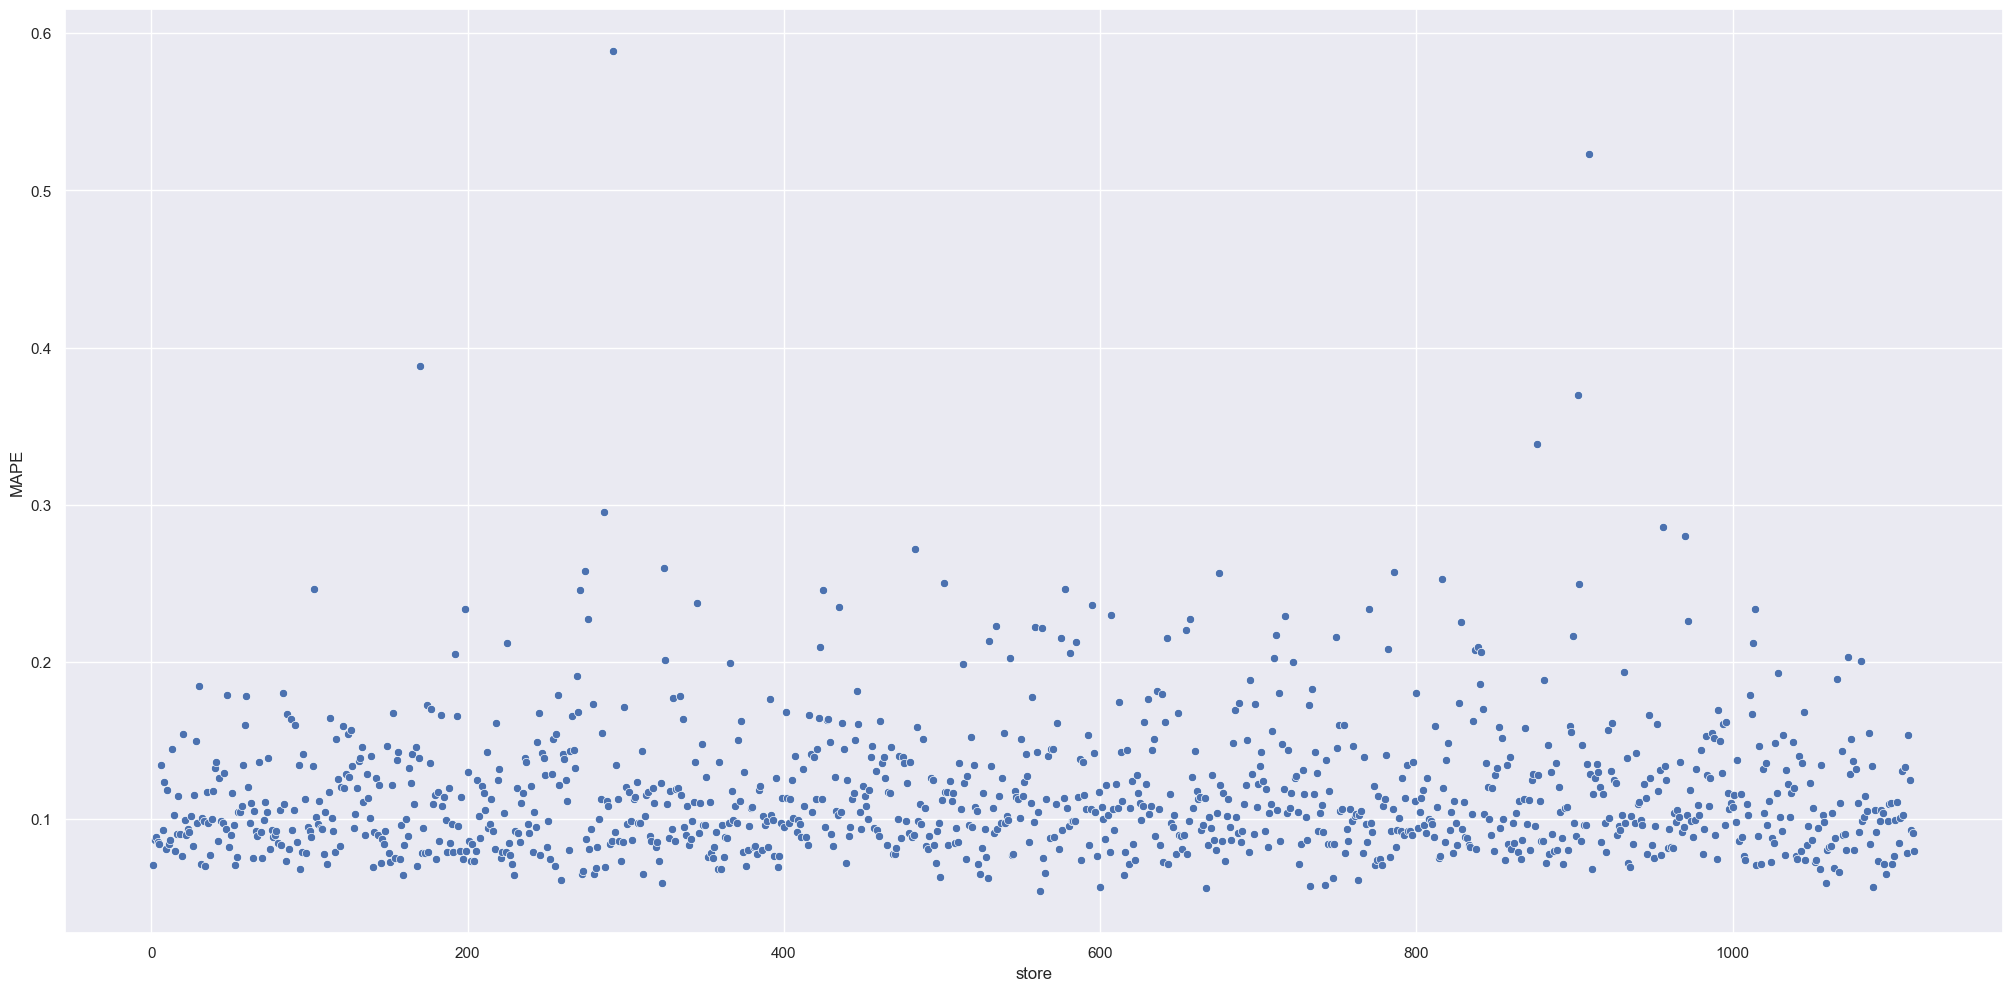

In [267]:
# Demonstração do erro em média de cada loja em gráfico de dispersão
sns.scatterplot(x='store', y='MAPE', data=df92)

### 9.2 Total Performance

In [268]:
# Melhor e pior cenário para todas as lojas
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$285,817,920.00"
1,worst_scenario,"R$284,955,855.73"
2,best_scenario,"R$286,679,971.81"


### 9.3  Machine Learning Performance

In [269]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot: xlabel='error', ylabel='Density'>

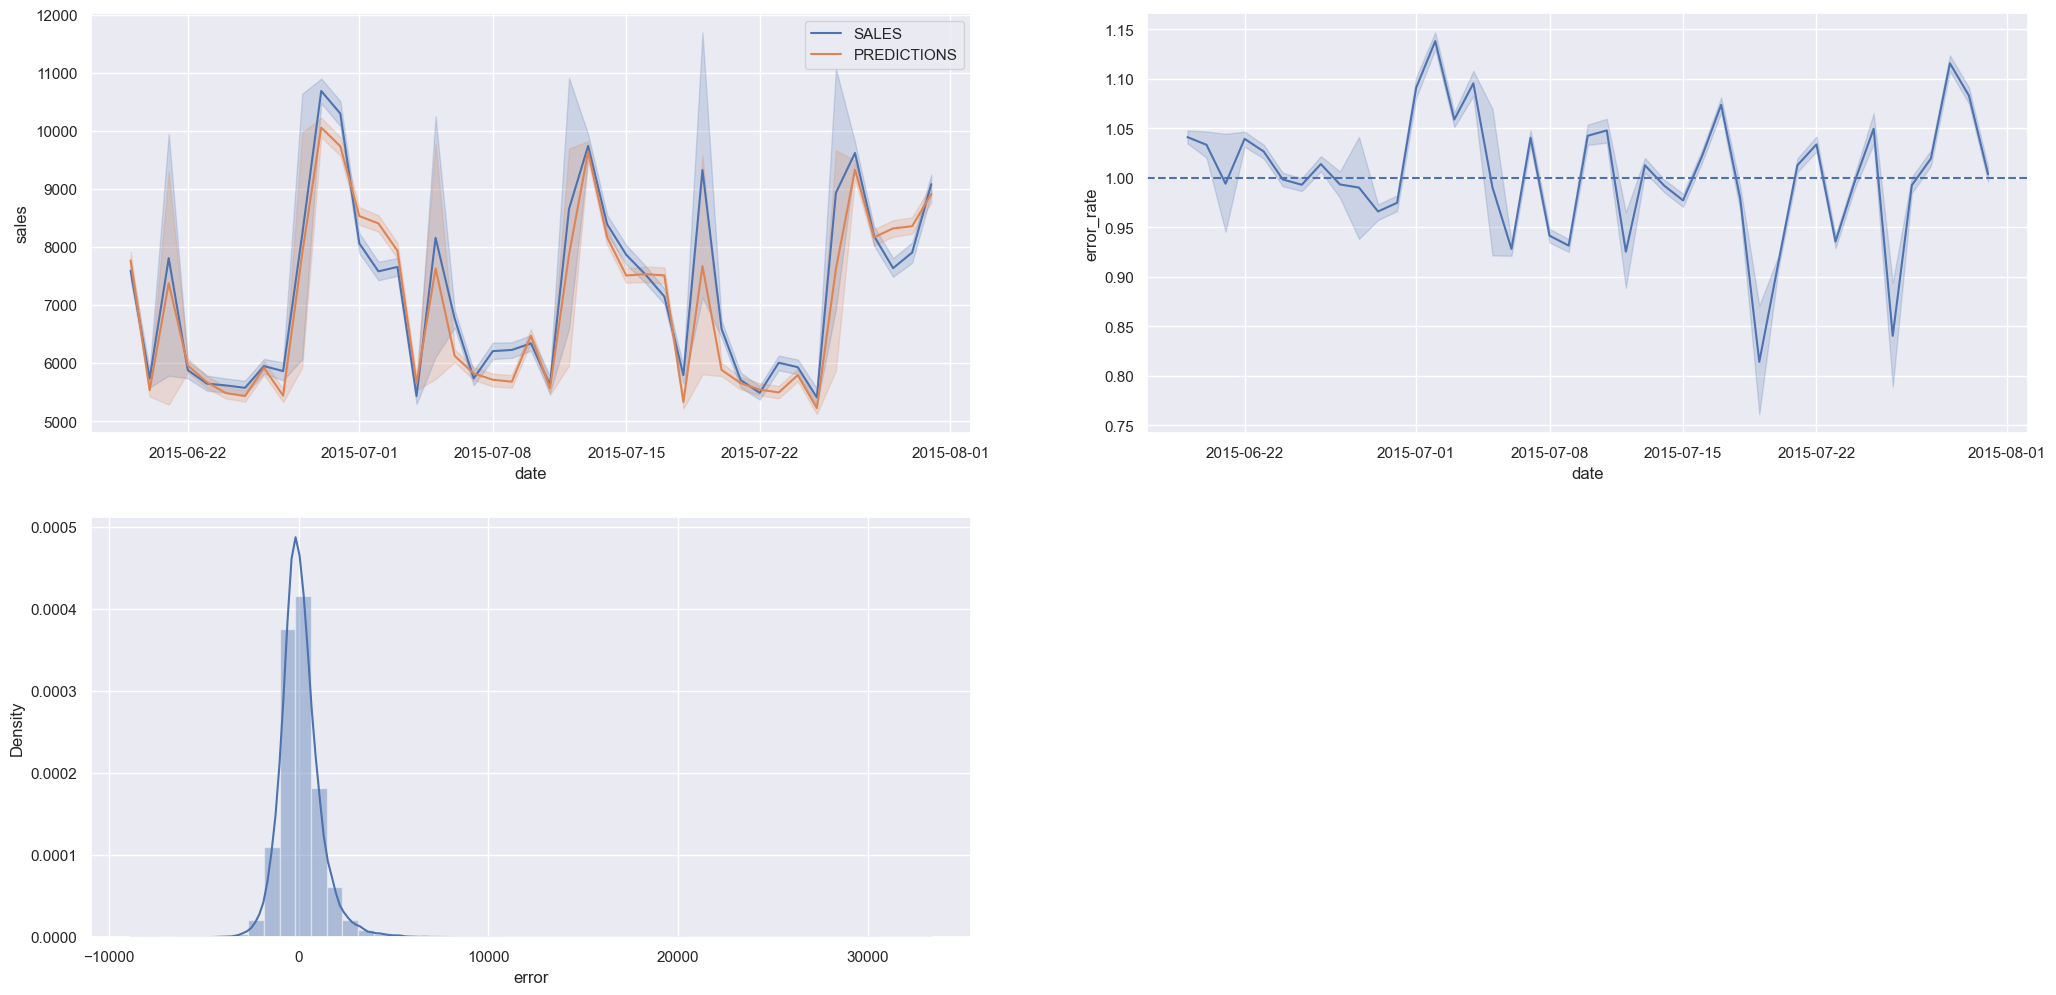

In [272]:
# Comportamento de vendas nas 6 semanas
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# Taxa de erro por dia: acima do 1 existe uma superestimação e abaixo do 1 são dias que o modelo fez uma subestimação
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

# Gráfico para saber se o erro tem uma distribuição parecida com a normal (aqui aparece uma distribuição próxima da normal - gaussiana)
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

# Gráfico para observação e análise de resíduos
#plt.subplot( 2, 2, 4 )
#sns.scatterplot( df9['predictions'], df9['error'] )

## Passo 10 - DEPLOY DO MODELO EM PRODUÇÃO

In [273]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('output/modelo_rossmann.pkl', 'wb'))

### 10.1  Rossmann Class

In [ ]:
# Criação da classe Rossmann que se encontra no arquivo Rossmann.py

### 10.2 API Handler

In [ ]:
# Desenvolvimento da API Handler para testar os dados inéditos (test.csv)

### 10.3 API Tester - predições em dados reais

In [4]:
# loading test dataset
df10 = pd.read_csv( 'test.csv' )

In [5]:
# Colunas do df de teste (dados nunca vistos)
df_store_raw.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
# Merge entre o dataset de test e df10
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# Escolhendo algumas lojas para testar
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# Removendo os dias que a loja está fechada/ remove Id porque não é usado
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [7]:
import json

In [8]:
# Converte o dataframe em uma lista Json -> records=chave/valor
data = json.dumps( df_test.to_dict( orient='records' ) )

In [9]:
# API Call
import requests#192.168.0.83:5000
url = 'http://192.168.0.83:5000/rossmann/predict' #endpoint (5000 é a porta default do Flask)
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } #indica para a API o tipo de dado
data = data

r = requests.post( url, data=data, headers=header ) #requisição (post=envia)
print( 'Status Code {}'.format( r.status_code ) ) # 200 ocorreu tudo bem

Status Code 200


In [10]:
# Para trazer de volta em formato de dataframe 
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [13]:
# Fazer a previsão em $ por loja
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$288,097.57 in the next 6 weeks
Store Number 22 will sell R$217,173.17 in the next 6 weeks
Store Number 23 will sell R$237,742.96 in the next 6 weeks
